In [1]:
import pandas as pd
import os
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown

import sys
sys.path.append('../')

from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utilities import data, roc, threshold, output, info
from utilities.info import *

In [2]:
# FIG_DIR = f"{TEAMS_DIR}/melba-figs"
# TAB_DIR = f"{TEAMS_DIR}/melba-tables"

print("FILES:\t", FILE_DIR)
print("RESULT:\t", RESULTS_DIR)
print("FIGS:\t", FIG_DIR)
print("TABLES:\t", TAB_DIR)

FILES:	 C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Data/melba-files-2
RESULT:	 C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Data/melba-results-2
FIGS:	 C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Data/melba-figs-2
TABLES:	 C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Data/melba-tables-2


In [3]:
POLICIES_TO_USE = ['90% Sensitivity', '90% Specificity', 'Brock ILST (6%)']
TABLE_SCORE_PRECISION = 2
MIN_MAL = 15
TOP_N_CONFOUNDERS = 10

In [4]:
nlst_preds_nodule = pd.read_csv(f"{FILE_DIR}/nlst_allmodels_demos.csv")
nlst_preds_nodule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 130 entries, PatientID to sybil_label
dtypes: bool(28), float64(84), int64(14), object(4)
memory usage: 12.9+ MB


In [5]:
with open(f'{FILE_DIR}/nlst_democols.json') as json_data:
    nlst_democols_og = json.load(json_data)
    json_data.close()

nlst_democols_og

{'num': {'demo': ['weight', 'height', 'BMI', 'Age'],
  'smoke': ['pkyr', 'smokeage', 'smokeday', 'smokeyr'],
  'nodule': ['CoordX', 'CoordY', 'CoordZ'],
  'other': ['Diameter_mm', 'NoduleCounts']},
 'cat': {'demo': ['HS-or-more',
   'HighSchoolPlus',
   'educat',
   'more-than-HS',
   'Married',
   'Unfinished_ed',
   'WhiteOrBlack',
   'NonHispanicWhite',
   'race',
   'ethnic',
   'marital',
   'Overweight',
   'Gender'],
  'smoke': ['cigar', 'cigsmok', 'pipe', 'smokelive', 'smokework'],
  'work': ['wrkasbe',
   'wrkbaki',
   'wrkbutc',
   'wrkchem',
   'wrkcoal',
   'wrkcott',
   'wrkfarm',
   'wrkfire',
   'wrkflou',
   'wrkfoun',
   'wrkhard',
   'wrkpain',
   'wrksand',
   'wrkweld'],
  'disease': ['diagadas',
   'diagasbe',
   'diagbron',
   'diagchas',
   'diagchro',
   'diagcopd',
   'diagdiab',
   'diagemph',
   'diagfibr',
   'diaghear',
   'diaghype',
   'diagpneu',
   'diagsarc',
   'diagsili',
   'diagstro',
   'diagtube'],
  'canchist': ['cancblad',
   'cancbrea',
   'ca

# Materials

## Demographic characteristics of the NLST validation set (n=5911 scans).

In [6]:
nlst_5911, nlst_democols, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, sybil=True, pretty=True, bin_num=False)
len(nlst_5911)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:457: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


5911

In [7]:
df_out, invalid_attributes_5911 = output.dataset_malben_table(nlst_5911, nlst_democols)
df_out

full: 5330 ben 581 mal
invalid: 36
valid: 49


Malignant (n=581)  \
Category     Characteristic         Subgroup                              
Demographics Education              0.0                        41 (7.1)   
                                    1.0                      526 (90.5)   
             HS Education           0.0                         9 (1.5)   
                                    1.0                      572 (98.5)   
             Education Status       8th grade or less           9 (1.5)   
...                                                                 ...   
Smoking      Age at Smoking Onset   Median (IQR)                 16 (4)   
             Cigarettes per Day     Median (IQR)                30 (20)   
             Total Years of Smoking Median (IQR)                44 (10)   
Other        Diameter (mm)          Median (IQR)                 12 (9)   
             Nodules Per Scan       Median (IQR)                  2 (2)   

                                                      Benign (n=5330)  \
Category     Characteristic         Subgroup                            
Demographics Education              0.0                     360 (6.8)   
                                    1.0                   4873 (91.4)   
             HS Education           0.0                     102 (1.9)   
                                    1.0                   5228 (98.1)   
             Education Status       8th grade or less       102 (1.9)   
...                                                               ...   
Smoking      Age at Smoking Onset   Median (IQR)               16 (3)   
             Cigarettes per Day     Median (IQR)              25 (15)   
             Total Years of Smoking Median (IQR)              41 (10)   
Other        Diameter (mm)          Median (IQR)                6 (4)   
             Nodules Per Scan       Median (IQR)                1 (1)   

                                                      All Scans (n=5911)  
Category     Characteristic         Subgroup                              
Demographics Education              0.0                        401 (6.8)  
                                    1.0                      5399 (91.3)  
             HS Education           0.0                        111 (1.9)  
                                    1.0                      5800 (98.1)  
             Education Status       8th grade or less          111 (1.9)  
...                                                                  ...  
Smoking      Age at Smoking Onset   Median (IQR)                  16 (4)  
             Cigarettes per Day     Median (IQR)                 25 (15)  
             Total Years of Smoking Median (IQR)                 41 (10)  
Other        Diameter (mm)          Median (IQR)                   7 (5)  
             Nodules Per Scan       Median (IQR)                   1 (1)  

[196 rows x 3 columns]

In [8]:
demos_no_duplicates = [data.rename_cols[c] for c in ['race','ethnic','educat','Gender','weight','height', 'BMI', 'Age']]
df_out2 = df_out.xs('Demographics', level='Category').query("Characteristic in @demos_no_duplicates")
df_out2

Malignant (n=581) Benign (n=5330)  \
Characteristic   Subgroup                                                
Education Status 8th grade or less             9 (1.5)       102 (1.9)   
                 9th-11th grade               32 (5.5)       258 (4.8)   
                 Associate Degree           126 (21.7)     1175 (22.0)   
                 Bachelors Degree            96 (16.5)      817 (15.3)   
                 Graduate School             76 (13.1)      778 (14.6)   
                 HS Graduate / GED          141 (24.3)     1338 (25.1)   
                 Post-HS training            87 (15.0)      765 (14.4)   
Race             Asian                         6 (1.0)        66 (1.2)   
                 Black                        28 (4.8)       160 (3.0)   
                 More than one race            6 (1.0)        59 (1.1)   
                 Native American               8 (1.4)        15 (0.3)   
                 Native Hawaiian               1 (0.2)        17 (0.3)   
                 White                      530 (91.2)     4993 (93.7)   
Ethnicity        Hispanic/Latino               4 (0.7)        94 (1.8)   
                 Not Hispanic/Latino        574 (98.8)     5205 (97.7)   
Sex              Female                     244 (42.0)     2226 (41.8)   
                 Male                       337 (58.0)     3104 (58.2)   
Weight           Median (IQR)                 175 (50)        180 (50)   
Height           Median (IQR)                   68 (6)          68 (6)   
Body Mass Index  Median (IQR)                   26 (4)          27 (6)   
Age              Median (IQR)                   64 (8)          62 (8)   

                                     All Scans (n=5911)  
Characteristic   Subgroup                                
Education Status 8th grade or less            111 (1.9)  
                 9th-11th grade               290 (4.9)  
                 Associate Degree           1301 (22.0)  
                 Bachelors Degree            913 (15.4)  
                 Graduate School             854 (14.4)  
                 HS Graduate / GED          1479 (25.0)  
                 Post-HS training            852 (14.4)  
Race             Asian                         72 (1.2)  
                 Black                        188 (3.2)  
                 More than one race            65 (1.1)  
                 Native American               23 (0.4)  
                 Native Hawaiian               18 (0.3)  
                 White                      5523 (93.4)  
Ethnicity        Hispanic/Latino               98 (1.7)  
                 Not Hispanic/Latino        5779 (97.8)  
Sex              Female                     2470 (41.8)  
                 Male                       3441 (58.2)  
Weight           Median (IQR)                  180 (50)  
Height           Median (IQR)                    68 (6)  
Body Mass Index  Median (IQR)                    26 (6)  
Age              Median (IQR)                    62 (8)

In [9]:
print(df_out2.style.format(precision=1, na_rep='-').format_index(output.latex_replace_arrowbrackets).format(output.latex_replace_arrowbrackets).to_latex(
    buf=f"{TAB_DIR}/datasetDemos.tex",
    hrules=True, label='tab:datasetDemos', environment='table*', column_format='ll|rrr', position='ht!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographic characteristics of the NLST validation set (n={len(nlst_5911)} scans). HS = High School.'))

None


### Venk21 Training Set

In [10]:
venk21_full, venk21_democols, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, sybil=False, pretty=True, bin_num=False)
len(venk21_full)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:455: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[att] = df[att].replace(keys[att])
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[att] = df[att].replace(binary_key)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:457: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. T

10183

In [11]:
venk21_datatable, _ = output.dataset_malben_table(venk21_full, venk21_democols)
venk21_datatable = venk21_datatable.xs('Demographics', level='Category').query("Characteristic in @demos_no_duplicates")
venk21_datatable

full: 8984 ben 1199 mal
invalid: 26
valid: 59


Malignant (n=1199) Benign (n=8984)  \
Characteristic   Subgroup                                                 
Education Status 8th grade or less             24 (2.0)       140 (1.6)   
                 9th-11th grade                68 (5.7)       450 (5.0)   
                 Associate Degree            295 (24.6)     1992 (22.2)   
                 Bachelors Degree            182 (15.2)     1403 (15.6)   
                 Graduate School             134 (11.2)     1331 (14.8)   
                 HS Graduate / GED           300 (25.0)     2238 (24.9)   
                 Post-HS training            171 (14.3)     1275 (14.2)   
Race             Asian                         19 (1.6)       150 (1.7)   
                 Black                         56 (4.7)       282 (3.1)   
                 More than one race            10 (0.8)       101 (1.1)   
                 Native American                9 (0.8)        34 (0.4)   
                 Native Hawaiian                2 (0.2)        31 (0.3)   
                 White                      1101 (91.8)     8360 (93.1)   
Ethnicity        Hispanic/Latino                9 (0.8)       141 (1.6)   
                 Not Hispanic/Latino        1180 (98.4)     8797 (97.9)   
Sex              Female                      501 (41.8)     3848 (42.8)   
                 Male                        698 (58.2)     5136 (57.2)   
Weight           Median (IQR)                  174 (50)        180 (50)   
Height           Median (IQR)                    68 (6)          68 (6)   
Body Mass Index  Median (IQR)                    26 (4)          27 (6)   
Age              Median (IQR)                    64 (8)          62 (8)   

                                     All Scans (n=10183)  
Characteristic   Subgroup                                 
Education Status 8th grade or less             164 (1.6)  
                 9th-11th grade                518 (5.1)  
                 Associate Degree            2287 (22.5)  
                 Bachelors Degree            1585 (15.6)  
                 Graduate School             1465 (14.4)  
                 HS Graduate / GED           2538 (24.9)  
                 Post-HS training            1446 (14.2)  
Race             Asian                         169 (1.7)  
                 Black                         338 (3.3)  
                 More than one race            111 (1.1)  
                 Native American                43 (0.4)  
                 Native Hawaiian                33 (0.3)  
                 White                       9461 (92.9)  
Ethnicity        Hispanic/Latino               150 (1.5)  
                 Not Hispanic/Latino         9977 (98.0)  
Sex              Female                      4349 (42.7)  
                 Male                        5834 (57.3)  
Weight           Median (IQR)                   180 (50)  
Height           Median (IQR)                     68 (6)  
Body Mass Index  Median (IQR)                     27 (6)  
Age              Median (IQR)                     62 (8)

In [12]:
print(venk21_datatable.style.format(precision=1, na_rep='-').format_index(output.latex_replace_arrowbrackets).format(output.latex_replace_arrowbrackets).to_latex(
    buf=f"{TAB_DIR}/venk21trainData.tex",
    hrules=True, label='tab:venk21trainData', environment='table*', column_format='ll|rrr', position='ht!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographics of the NLST training set used for Venkadesh21 (n={len(venk21_full)} scans). HS = High School.'))

None


### Sybil Training Set

In [13]:
sybil_train = pd.read_csv(f"{FILE_DIR}/nlst_sybil_demos.csv").query('split == "train"')
sybil_train['label'] = sybil_train['sybil_label']
sybil_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28160 entries, 0 to 28159
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             28160 non-null  object 
 1   split                          28160 non-null  object 
 2   PatientID                      28160 non-null  int64  
 3   timepoint                      28160 non-null  int64  
 4   SeriesInstanceUID              28160 non-null  object 
 5   weight                         28088 non-null  float64
 6   height                         28123 non-null  float64
 7   BMI                            28066 non-null  float64
 8   Age                            28160 non-null  int64  
 9   pkyr                           28160 non-null  float64
 10  smokeage                       28160 non-null  float64
 11  smokeday                       28160 non-null  int64  
 12  smokeyr                        28160 non-null  int6

In [14]:
with open(f'{FILE_DIR}/nlst_sybil_democols.json') as json_data:
    sybil_democols = json.load(json_data)
    json_data.close()

In [15]:
sybil_train, sybil_democols = data.nlst_pretty_labels(sybil_train, sybil_democols)
sybil_democols

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:457: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


{'num': {'Demographics': ['Weight', 'Height', 'Body Mass Index', 'Age'],
  'Smoking': ['Pack-Years',
   'Age at Smoking Onset',
   'Cigarettes per Day',
   'Total Years of Smoking']},
 'cat': {'Demographics': ['Education',
   'HS Education',
   'Education Status',
   'Post-HS Education',
   'Married',
   'Unfinished Education',
   'White or Black',
   'Non-Hispanic White',
   'Race',
   'Ethnicity',
   'Marital Status',
   'BMI',
   'Sex'],
  'Smoking': ['Smoked Cigars',
   'Current Smoker',
   'Smoked Pipe',
   'Lived w/ Smoker',
   'Worked w/ Smoker'],
  'Work History': ['Work - Asbestos',
   'Work - Baking',
   'Work - Butchering or Meat Packing',
   'Work - Chemicals or Plastics Mfg.',
   'Work - Coal Mining',
   'Work - Cotton or Jute Processing',
   'Work - Farming',
   'Work - Firefighting',
   'Work - Flour/Feed or Grain Milling',
   'Work - Foundry or Steel Milling',
   'Work - Hard Rock Mining',
   'Work - Painting',
   'Work - Sandblasting',
   'Work - Welding'],
  'Disease 

In [16]:
sybil_datatable, _ = output.dataset_malben_table(sybil_train, sybil_democols)
sybil_datatable = sybil_datatable.xs('Demographics', level='Category').query("Characteristic in @demos_no_duplicates")
sybil_datatable

full: 26716 ben 1444 mal
invalid: 22
valid: 53


Malignant (n=1444) Benign (n=26716)  \
Characteristic   Subgroup                                                  
Education Status 8th grade or less             42 (2.9)        311 (1.2)   
                 9th-11th grade                76 (5.3)       1189 (4.5)   
                 Associate Degree            335 (23.2)      6312 (23.6)   
                 Bachelors Degree            191 (13.2)      4645 (17.4)   
                 Graduate School              129 (8.9)      3847 (14.4)   
                 HS Graduate / GED           416 (28.8)      6165 (23.1)   
                 Post-HS training            224 (15.5)      3767 (14.1)   
Race             Asian                         23 (1.6)        552 (2.1)   
                 Black                         68 (4.7)        968 (3.6)   
                 More than one race            13 (0.9)        352 (1.3)   
                 Native American                6 (0.4)         90 (0.3)   
                 Native Hawaiian                1 (0.1)         69 (0.3)   
                 White                      1333 (92.3)     24586 (92.0)   
Ethnicity        Hispanic/Latino               10 (0.7)        505 (1.9)   
                 Not Hispanic/Latino        1423 (98.5)     26106 (97.7)   
Sex              Female                      604 (41.8)     10984 (41.1)   
                 Male                        840 (58.2)     15732 (58.9)   
Weight           Median (IQR)                  175 (50)         180 (53)   
Height           Median (IQR)                    68 (6)           68 (6)   
Body Mass Index  Median (IQR)                    26 (5)           27 (6)   
Age              Median (IQR)                    63 (9)           61 (8)   

                                     All Scans (n=28160)  
Characteristic   Subgroup                                 
Education Status 8th grade or less             353 (1.3)  
                 9th-11th grade               1265 (4.5)  
                 Associate Degree            6647 (23.6)  
                 Bachelors Degree            4836 (17.2)  
                 Graduate School             3976 (14.1)  
                 HS Graduate / GED           6581 (23.4)  
                 Post-HS training            3991 (14.2)  
Race             Asian                         575 (2.0)  
                 Black                        1036 (3.7)  
                 More than one race            365 (1.3)  
                 Native American                96 (0.3)  
                 Native Hawaiian                70 (0.2)  
                 White                      25919 (92.0)  
Ethnicity        Hispanic/Latino               515 (1.8)  
                 Not Hispanic/Latino        27529 (97.8)  
Sex              Female                     11588 (41.2)  
                 Male                       16572 (58.8)  
Weight           Median (IQR)                   180 (53)  
Height           Median (IQR)                     68 (6)  
Body Mass Index  Median (IQR)                     27 (6)  
Age              Median (IQR)                     61 (8)

In [17]:
print(sybil_datatable.style.format(precision=1, na_rep='-').format_index(output.latex_replace_arrowbrackets).format(output.latex_replace_arrowbrackets).to_latex(
    buf=f"{TAB_DIR}/sybilTrainData.tex",
    hrules=True, label='tab:sybilTrainData', environment='table*', column_format='ll|rrr', position='ht!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographics of the NLST training set used for Sybil (n={len(sybil_train)} scans). HS = High School.'))

None


# Methods

### Thresholds from policies on validation sets.

In [18]:
nlst_5911, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, sybil=True, pretty=True, bin_num=False)
nlst_5911_policies, _ = threshold.get_threshold_policies(nlst_5911, models=output.NLST_5911_MODELCOLS, policies=[("Sensitivity", 0.9),("Specificity", 0.9)], brock=False)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:457: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [19]:
nlst_5911_policies.rename(columns=output.RENAME_POLICIES, inplace=True)
nlst_5911_policies

,90% Sensitivity,90% Specificity
Venkadesh21,0.049,0.222
Sybil (Year 1),0.003,0.058
PanCan2b,0.015,0.165


In [20]:
print(nlst_5911_policies.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/thresholds.tex",
    hrules=True, label='tab:thresholds', environment='table', column_format='l|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='Thresholds used to evaluate model performance on NLST. All models are also evaluated on the Brock ILST 6\% (0.06) moderate risk threshold \citep{Lim2020-ilst}.'))

None


# Results Part 1

## ROC Tables

In [40]:
nlst_demos_to_include = ['Age', 'Sex', 'Race', 'Education', 'Height', 'Weight', 'BMI']

In [41]:
nlst_scan_res = pd.read_csv(f"{RESULTS_DIR}/auroc-nlst-5911.csv", index_col=0)
nlst_model_order = ['Venkadesh', 'Sybil year 1', 'PanCan2b']
nlst_scan_out = output.roc_results_pretty(nlst_scan_res, nlst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
nlst_scan_out_demos = nlst_scan_out.xs('Demographics', level='Category').query('Attribute in @nlst_demos_to_include & Attribute not in @invalid_attributes_5911')
nlst_scan_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_26004\1404112098.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  nlst_scan_out = output.roc_results_pretty(nlst_scan_res, nlst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


Venkadesh21           Sybil (Year 1)          \
                              AUROC     p              AUROC       p   
Attribute Group                                                        
Age       > 61    0.88 (0.86, 0.90)  None  0.84 (0.82, 0.86)    None   
          ≤ 61    0.90 (0.88, 0.92)   .14  0.85 (0.82, 0.88)     .67   
BMI       ≥ 25    0.90 (0.88, 0.91)  None  0.86 (0.84, 0.88)    None   
          < 25    0.88 (0.85, 0.90)   .32  0.81 (0.78, 0.85)     .05   
Education ≥ HS    0.89 (0.88, 0.91)  None  0.85 (0.83, 0.86)    None   
          < HS    0.85 (0.78, 0.92)   .32  0.82 (0.75, 0.89)     .55   
Height    ≤ 68    0.89 (0.87, 0.91)  None  0.87 (0.85, 0.89)    None   
          > 68    0.88 (0.86, 0.91)   .67  0.80 (0.77, 0.83)  < .001   
Race      White   0.89 (0.88, 0.91)  None  0.84 (0.83, 0.86)    None   
          Black   0.82 (0.74, 0.89)   .14  0.83 (0.74, 0.90)     .77   
Sex       Male    0.89 (0.87, 0.91)  None  0.81 (0.78, 0.84)    None   
          Female  0.89 (0.87, 0.91)   .92  0.88 (0.86, 0.90)  < .001   
Weight    ≤ 180   0.88 (0.87, 0.90)  None  0.84 (0.82, 0.87)    None   
          > 180   0.89 (0.87, 0.91)   .65  0.84 (0.81, 0.87)     .82   

                           PanCan2b        
                              AUROC     p  
Attribute Group                            
Age       > 61    0.76 (0.74, 0.79)  None  
          ≤ 61    0.81 (0.78, 0.83)   .05  
BMI       ≥ 25    0.81 (0.79, 0.83)  None  
          < 25    0.73 (0.70, 0.77)  .001  
Education ≥ HS    0.78 (0.76, 0.80)  None  
          < HS    0.78 (0.71, 0.85)   .98  
Height    ≤ 68    0.79 (0.76, 0.81)  None  
          > 68    0.78 (0.75, 0.80)   .71  
Race      White   0.78 (0.76, 0.80)  None  
          Black   0.75 (0.65, 0.83)   .54  
Sex       Male    0.79 (0.76, 0.81)  None  
          Female  0.78 (0.75, 0.81)   .66  
Weight    ≤ 180   0.77 (0.74, 0.79)  None  
          > 180   0.80 (0.77, 0.82)   .13

In [42]:
print(nlst_scan_out_demos.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTscanROC.tex",
    hrules=True, label='tab:resNLSTscanROC', environment='table*', column_format=f'll{"|ll"*len(nlst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='AUROC (with 95\% confidence intervals) for models for demographic subgroups on NLST.'))

None


## ROC Plots

,num,pct,mal,ben,pct_mal
Female,2470,41.7865,244,2226,9.878543
Male,3441,58.2135,337,3104,9.793665


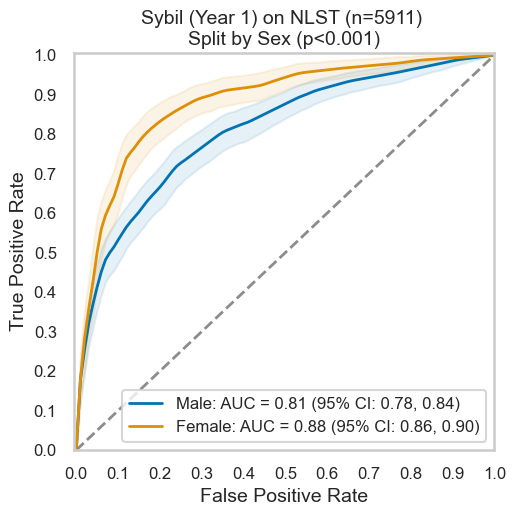

,p,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,AUC_diff
Sybil (Year 1),0.000363,Male,0.810375,0.783843,0.836403,Female,0.881035,0.856631,0.903728,0.07066


In [43]:
_ = roc.plot_rocs_subgroups(nlst_5911, 'Sex', models={'Sybil (Year 1)': 'sybil_year1'}, two_subgroups=True, dataset_name="NLST", num_bootstraps=1000, imgpath=f"{FIG_DIR}/sybilROCgender5911.png")

,num,pct,mal,ben,pct_mal
< 25,1899,32.126544,209,1690,11.005793
≥ 25,4012,67.873456,372,3640,9.272183


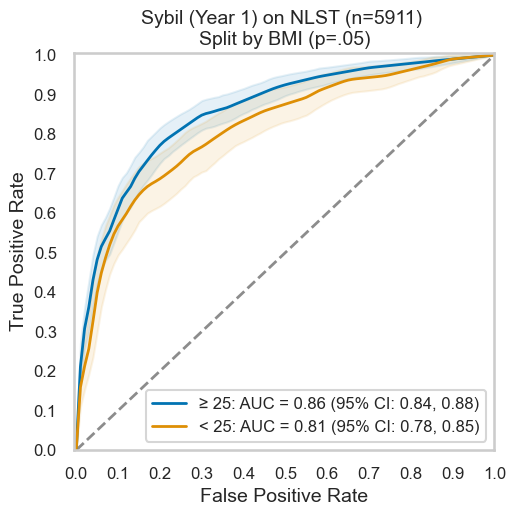

,p,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,AUC_diff
Sybil (Year 1),0.051435,≥ 25,0.856063,0.835375,0.87804,< 25,0.814306,0.779593,0.847962,-0.041758


In [44]:
_ = roc.plot_rocs_subgroups(nlst_5911, 'BMI', models={'Sybil (Year 1)': 'sybil_year1'}, two_subgroups=True, dataset_name="NLST", num_bootstraps=1000, imgpath=f"{FIG_DIR}/sybilBMIroc5911.png")

,num,pct,mal,ben,pct_mal
False,3755,63.52563,317,3438,8.442077
True,2156,36.47437,264,1892,12.244898


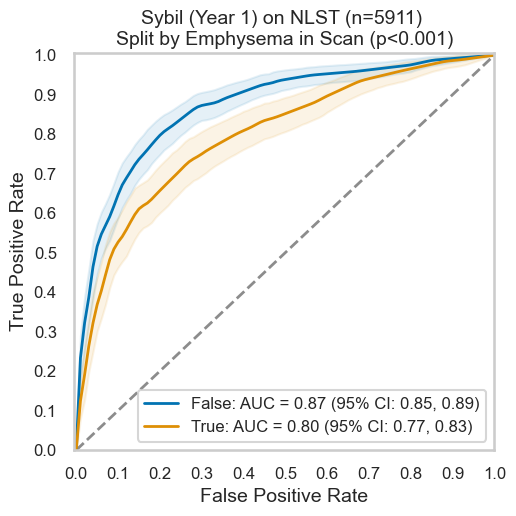

,p,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,AUC_diff
Sybil (Year 1),0.000453,False,0.869197,0.847325,0.889735,True,0.79729,0.767805,0.828122,-0.071907


In [45]:
_ = roc.plot_rocs_subgroups(nlst_5911, 'Emphysema in Scan', models={'Sybil (Year 1)': 'sybil_year1'}, two_subgroups=True, dataset_name="NLST", num_bootstraps=1000, imgpath=f"{FIG_DIR}/sybilROCemphysema5911.png")

## Threshold Utilities

In [46]:
threshold_nlst_5911 = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-nlst-5911.csv', index_col=0)
threshold_nlst_5911, nlst_5911_policies = output.threshold_stats_pretty(threshold_nlst_5911, nlst_5911_policies)

## Threshold Plots

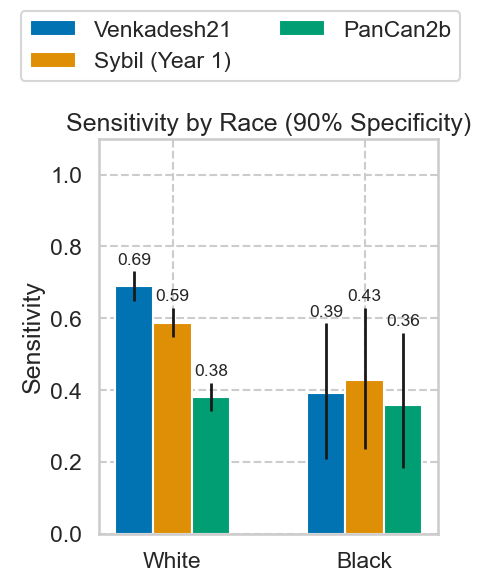

In [47]:
_ = threshold.plot_threshold_stats_subgroups(nlst_5911, "Race", dataset_name='NLST',
                                                policies=nlst_5911_policies[['90% Specificity']], models=output.NLST_5911_MODELCOLS, 
                                                stats=threshold_nlst_5911.query(f'attribute == "Race"'),
                                                plot_metrics=['Sensitivity'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/allTPRrace5911.png"
                                                )  

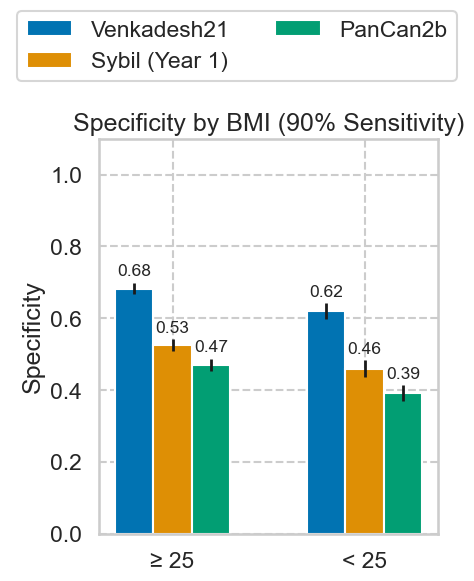

In [48]:
_ = threshold.plot_threshold_stats_subgroups(nlst_5911, "BMI", dataset_name='NLST',
                                                policies=nlst_5911_policies[['90% Sensitivity']], models=output.NLST_5911_MODELCOLS, 
                                                stats=threshold_nlst_5911.query(f'attribute == "BMI"'),
                                                plot_metrics=['Specificity'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/allTNRbmi5911.png"
                                                )  

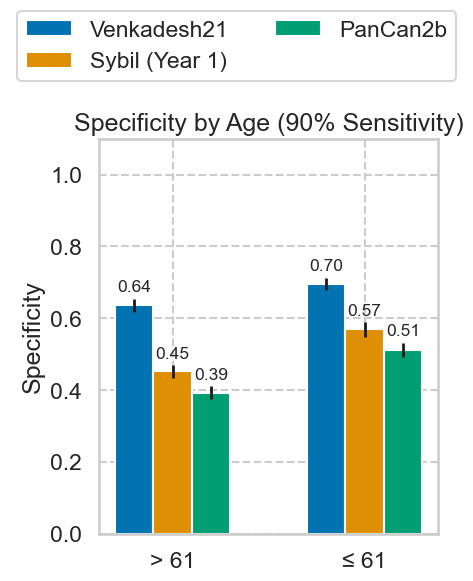

In [49]:
_ = threshold.plot_threshold_stats_subgroups(nlst_5911, "Age", dataset_name='NLST',
                                                policies=nlst_5911_policies[['90% Sensitivity']], models=output.NLST_5911_MODELCOLS, 
                                                stats=threshold_nlst_5911.query(f'attribute == "Age"'),
                                                plot_metrics=['Specificity'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/allTNRage5911.png"
                                                )  

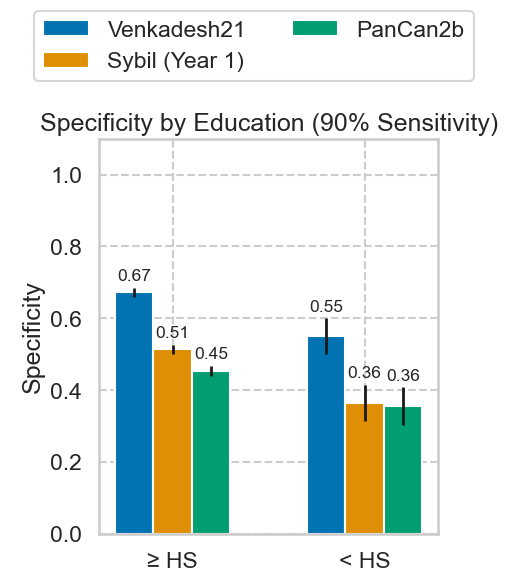

In [50]:
_ = threshold.plot_threshold_stats_subgroups(nlst_5911, "Education", dataset_name='NLST',
                                                policies=nlst_5911_policies[['90% Sensitivity']], models=output.NLST_5911_MODELCOLS, 
                                                stats=threshold_nlst_5911.query(f'attribute == "Education"'),
                                                plot_metrics=['Specificity'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/allTNReducation5911.png"
                                                )  

## Threshold Tables

In [51]:
pairwise_tpr_5911 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_5911, metric='Sensitivity')
threshold_tpr = output.threshold_results_pretty(pairwise_tpr_5911, model_order=list(output.NLST_5911_MODELCOLS.keys()), metric='Sensitivity')
tpr_demo_5911 = threshold_tpr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & Policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_5911')
tpr_demo_5911

Venkadesh21         Sybil (Year 1)  \
                                        Sensitivity  CI        Sensitivity   
Policy          Attribute Group                                              
90% Sensitivity Age       > 61    0.90 (0.86, 0.93)      0.91 (0.88, 0.94)   
                          ≤ 61    0.91 (0.87, 0.94)      0.90 (0.86, 0.94)   
                BMI       ≥ 25    0.90 (0.87, 0.93)      0.92 (0.89, 0.94)   
                          < 25    0.90 (0.86, 0.94)      0.89 (0.84, 0.93)   
                Education ≥ HS    0.90 (0.87, 0.92)      0.91 (0.88, 0.93)   
                          < HS    0.88 (0.77, 0.97)      0.90 (0.80, 0.98)   
                Height    ≤ 68    0.90 (0.87, 0.94)      0.92 (0.90, 0.95)   
                          > 68    0.90 (0.86, 0.93)      0.89 (0.85, 0.92)   
                Race      White   0.90 (0.88, 0.93)      0.91 (0.89, 0.93)   
                          Black   0.82 (0.67, 0.96)      0.86 (0.71, 0.97)   
                Sex       Male    0.90 (0.87, 0.93)      0.90 (0.86, 0.93)   
                          Female  0.90 (0.86, 0.93)      0.92 (0.89, 0.96)   
                Weight    ≤ 180   0.91 (0.88, 0.94)      0.92 (0.89, 0.95)   
                          > 180   0.89 (0.85, 0.93)      0.89 (0.86, 0.93)   
90% Specificity Age       > 61    0.70 (0.65, 0.75)      0.61 (0.56, 0.66)   
                          ≤ 61    0.65 (0.58, 0.71)      0.53 (0.47, 0.60)   
                BMI       ≥ 25    0.68 (0.63, 0.72)      0.58 (0.53, 0.62)   
                          < 25    0.69 (0.63, 0.75)      0.59 (0.52, 0.65)   
                Education ≥ HS    0.68 (0.64, 0.72)      0.59 (0.55, 0.63)   
                          < HS    0.68 (0.54, 0.82)      0.56 (0.41, 0.71)   
                Height    ≤ 68    0.70 (0.65, 0.75)      0.63 (0.58, 0.68)   
                          > 68    0.66 (0.61, 0.71)      0.52 (0.47, 0.58)   
                Race      White   0.69 (0.65, 0.73)      0.59 (0.55, 0.63)   
                          Black   0.39 (0.21, 0.59)  **  0.43 (0.24, 0.63)   
                Sex       Male    0.66 (0.61, 0.71)      0.53 (0.48, 0.58)   
                          Female  0.71 (0.65, 0.76)      0.66 (0.60, 0.71)   
                Weight    ≤ 180   0.69 (0.64, 0.74)      0.59 (0.54, 0.64)   
                          > 180   0.68 (0.62, 0.74)      0.57 (0.51, 0.63)   
Brock ILST (6%) Age       > 61    0.88 (0.84, 0.91)      0.61 (0.56, 0.66)   
                          ≤ 61    0.89 (0.85, 0.93)      0.53 (0.47, 0.60)   
                BMI       ≥ 25    0.89 (0.86, 0.92)      0.58 (0.53, 0.62)   
                          < 25    0.88 (0.82, 0.92)      0.59 (0.52, 0.65)   
                Education ≥ HS    0.88 (0.85, 0.91)      0.59 (0.55, 0.63)   
                          < HS    0.88 (0.77, 0.97)      0.56 (0.41, 0.71)   
                Height    ≤ 68    0.89 (0.85, 0.92)      0.63 (0.58, 0.68)   
                          > 68    0.88 (0.84, 0.91)      0.52 (0.47, 0.58)   
                Race      White   0.89 (0.86, 0.91)      0.59 (0.55, 0.63)   
                          Black   0.75 (0.59, 0.91)      0.43 (0.24, 0.63)   
                Sex       Male    0.88 (0.84, 0.92)      0.53 (0.48, 0.58)   
                          Female  0.89 (0.85, 0.92)      0.66 (0.60, 0.71)   
                Weight    ≤ 180   0.88 (0.84, 0.91)      0.59 (0.54, 0.64)   
                          > 180   0.89 (0.85, 0.92)      0.57 (0.51, 0.63)   

                                               PanCan2b      
                                  CI        Sensitivity  CI  
Policy          Attribute Group                              
90% Sensitivity Age       > 61        0.92 (0.89, 0.95)      
                          ≤ 61        0.87 (0.82, 0.91)   *  
                BMI       ≥ 25        0.91 (0.88, 0.94)      
                          < 25        0.88 (0.84, 0.92)      
                Education ≥ HS        0.90 (0.88, 0.93)      
                          < HS   

In [52]:
output.latex_rotate_multirow('90% Sensitivity')

'90% Sensitivity'

In [53]:
print(tpr_demo_5911.style
        .format_index(output.latex_rotate_multirow, escape='latex-math', axis=0)
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTfullTPR.tex",
    hrules=True, label='tab:resNLSTfullTPR', environment='table*', column_format=f'lll{"|ll"*len(list(output.NLST_5911_MODELCOLS.keys()))}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (with 95\% confidence intervals) for models for demographic subgroups on NLST. Single asterisk (*) = sensitivity of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [54]:
pairwise_tnr_5911 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_5911, metric='Specificity')
threshold_tnr = output.threshold_results_pretty(pairwise_tnr_5911, model_order=list(output.NLST_5911_MODELCOLS.keys()), metric='Specificity')
tnr_demo_5911 = threshold_tnr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & Policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_5911')
tnr_demo_5911

Venkadesh21         Sybil (Year 1)  \
                                        Specificity  CI        Specificity   
Policy          Attribute Group                                              
90% Sensitivity Age       > 61    0.64 (0.62, 0.65)      0.45 (0.43, 0.47)   
                          ≤ 61    0.70 (0.68, 0.71)  **  0.57 (0.55, 0.59)   
                BMI       ≥ 25    0.68 (0.67, 0.70)      0.53 (0.51, 0.54)   
                          < 25    0.62 (0.60, 0.64)  **  0.46 (0.44, 0.48)   
                Education ≥ HS    0.67 (0.66, 0.69)      0.51 (0.50, 0.53)   
                          < HS    0.55 (0.50, 0.60)  **  0.36 (0.31, 0.41)   
                Height    ≤ 68    0.68 (0.66, 0.70)      0.55 (0.53, 0.57)   
                          > 68    0.64 (0.63, 0.66)   *  0.45 (0.43, 0.47)   
                Race      White   0.66 (0.65, 0.67)      0.50 (0.49, 0.51)   
                          Black   0.73 (0.66, 0.80)      0.59 (0.52, 0.66)   
                Sex       Male    0.65 (0.63, 0.66)      0.46 (0.45, 0.48)   
                          Female  0.68 (0.66, 0.70)   *  0.56 (0.54, 0.58)   
                Weight    ≤ 180   0.65 (0.63, 0.67)      0.49 (0.47, 0.51)   
                          > 180   0.68 (0.66, 0.69)   *  0.51 (0.49, 0.53)   
90% Specificity Age       > 61    0.88 (0.87, 0.89)      0.89 (0.88, 0.90)   
                          ≤ 61    0.92 (0.91, 0.93)  **  0.92 (0.91, 0.93)   
                BMI       ≥ 25    0.91 (0.90, 0.92)      0.91 (0.90, 0.92)   
                          < 25    0.87 (0.86, 0.89)  **  0.89 (0.87, 0.90)   
                Education ≥ HS    0.90 (0.89, 0.91)      0.90 (0.90, 0.91)   
                          < HS    0.86 (0.83, 0.90)   *  0.89 (0.86, 0.92)   
                Height    ≤ 68    0.90 (0.89, 0.91)      0.90 (0.89, 0.92)   
                          > 68    0.90 (0.89, 0.92)      0.90 (0.89, 0.91)   
                Race      White   0.90 (0.89, 0.91)      0.90 (0.90, 0.91)   
                          Black   0.93 (0.89, 0.97)      0.92 (0.88, 0.96)   
                Sex       Male    0.90 (0.89, 0.91)      0.90 (0.89, 0.91)   
                          Female  0.90 (0.88, 0.91)      0.90 (0.89, 0.91)   
                Weight    ≤ 180   0.89 (0.88, 0.90)      0.89 (0.88, 0.91)   
                          > 180   0.91 (0.90, 0.92)  **  0.91 (0.90, 0.92)   
Brock ILST (6%) Age       > 61    0.67 (0.65, 0.69)      0.89 (0.88, 0.90)   
                          ≤ 61    0.73 (0.71, 0.75)  **  0.92 (0.91, 0.93)   
                BMI       ≥ 25    0.72 (0.70, 0.73)      0.91 (0.90, 0.92)   
                          < 25    0.66 (0.63, 0.68)  **  0.89 (0.87, 0.90)   
                Education ≥ HS    0.71 (0.69, 0.72)      0.90 (0.90, 0.91)   
                          < HS    0.59 (0.55, 0.64)  **  0.89 (0.86, 0.92)   
                Height    ≤ 68    0.71 (0.70, 0.73)      0.90 (0.89, 0.92)   
                          > 68    0.68 (0.66, 0.69)  **  0.90 (0.89, 0.91)   
                Race      White   0.69 (0.68, 0.71)      0.90 (0.90, 0.91)   
                          Black   0.76 (0.68, 0.82)      0.92 (0.88, 0.96)   
                Sex       Male    0.68 (0.66, 0.70)      0.90 (0.89, 0.91)   
                          Female  0.72 (0.70, 0.74)  **  0.90 (0.89, 0.91)   
                Weight    ≤ 180   0.69 (0.67, 0.70)      0.89 (0.88, 0.91)   
                          > 180   0.71 (0.69, 0.72)   *  0.91 (0.90, 0.92)   

                                               PanCan2b      
                                  CI        Specificity  CI  
Policy          Attribute Group                              
90% Sensitivity Age       > 61        0.39 (0.38, 0.41)      
                          ≤ 61    **  0.51 (0.49, 0.53)  **  
                BMI       ≥ 25        0.47 (0.45, 0.49)      
                          < 25    **  0.39 (0.37, 0.41)  **  
                Education ≥ HS        0.45 (0.44, 0.47)      
                          < HS   

In [55]:
print(tnr_demo_5911.style
        .format_index(output.latex_rotate_multirow, escape='latex-math', axis=0)
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTfullTNR.tex",
    hrules=True, label='tab:resNLSTfullTNR', environment='table*', column_format=f'lll{"|ll"*len(list(output.NLST_5911_MODELCOLS.keys()))}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (with 95\% confidence intervals) for models for demographic subgroups on NLST. Single asterisk (*) = specificity of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


# Confounder Results

## Prevalence + ROC Tables

In [56]:
nlst_5911_v2, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, sybil=True, pretty=False, bin_num=True)

### Sex

In [57]:
gender_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-gender-by-factors-nlst-5911.csv', index_col=0)
gender_prev_roc, gender_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'Gender',
    NLST_POSSIBLE_CONFOUNDERS,
    gender_roc,
    'Sybil (Year 1)',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(gender_prev_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/genderIsolationPlusROC.tex",
    hrules=True, label='tab:genderIsolationPlusROC', environment='sidewaystable*', column_format=f'll|rrrr|rrrr|l', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between sexes, and the AUROC scores of the Sybil (Year 1) model between men and women, isolating for them.'))

gender_prev_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:560: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:579: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df2 = df2.drop(columns=["Difference", "Abs Diff"]).droplevel(0)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:589: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Male                                  Female        \
                           Mal   Ben Total %              AUROC    Mal   Ben   
Confounder         Subset                                                      
Height             > 68    257  2364    76.2  0.80 (0.77, 0.83)     10   136   
                   ≤ 68     80   740    23.8  0.84 (0.79, 0.88)    234  2090   
Weight             > 180   211  2015    64.7  0.83 (0.80, 0.86)     36   554   
                   ≤ 180   126  1089    35.3  0.77 (0.72, 0.82)    208  1672   
Smoked Pipe        False   197  1967    62.9  0.82 (0.79, 0.85)    239  2172   
                   True    138  1118    36.5  0.80 (0.76, 0.84)      5    40   
Smoked Cigars      True    102   963    31.0  0.79 (0.74, 0.83)      7    76   
                   False   233  2127    68.6  0.82 (0.79, 0.86)    237  2141   
Work w/o Mask      False   228  2029    65.6  0.82 (0.79, 0.85)    214  1936   
                   True    109  1075    34.4  0.79 (0.74, 0.84)     30   290   
Pack-Years         ≤ 55    141  1601    50.6  0.81 (0.77, 0.85)    144  1504   
                   > 55    196  1503    49.4  0.80 (0.77, 0.84)    100   722   
BMI                < 25     92   811    26.2  0.76 (0.70, 0.82)    117   879   
                   ≥ 25    245  2293    73.8  0.83 (0.80, 0.86)    127  1347   
Cigarettes per Day ≤ 25    141  1473    46.9  0.80 (0.76, 0.84)    139  1366   
                   > 25    196  1631    53.1  0.82 (0.78, 0.85)    105   860   
Lived w/ Smoker    False    43   498    15.7  0.81 (0.74, 0.89)     21   103   
                   True    292  2585    83.6  0.81 (0.78, 0.84)    222  2112   
Pneumonia Diag.    True     55   597    18.9  0.68 (0.59, 0.77)     81   649   
                   False   281  2502    80.9  0.84 (0.81, 0.86)    157  1574   

                                                           p  
                          Total %              AUROC          
Confounder         Subset                                     
Height             > 68       5.9  0.84 (0.69, 0.96)     .63  
                   ≤ 68      94.1  0.88 (0.86, 0.90)     .17  
Weight             > 180     23.9  0.86 (0.77, 0.93)     .44  
                   ≤ 180     76.1  0.88 (0.86, 0.90)  < .001  
Smoked Pipe        False     97.6  0.88 (0.85, 0.90)     .01  
                   True       1.8  0.97 (0.93, 1.00)    .002  
Smoked Cigars      True       3.4  0.97 (0.92, 1.00)    .001  
                   False     96.3  0.88 (0.85, 0.90)     .01  
Work w/o Mask      False     87.0  0.89 (0.87, 0.91)  < .001  
                   True      13.0  0.79 (0.69, 0.87)     .92  
Pack-Years         ≤ 55      66.7  0.87 (0.83, 0.90)     .06  
                   > 55      33.3  0.90 (0.86, 0.93)  < .001  
BMI                < 25      40.3  0.85 (0.81, 0.89)    .009  
                   ≥ 25      59.7  0.90 (0.87, 0.93)    .003  
Cigarettes per Day ≤ 25      60.9  0.86 (0.82, 0.89)     .06  
                   > 25      39.1  0.91 (0.88, 0.94)  < .001  
Lived w/ Smoker    False      5.0  0.85 (0.75, 0.93)     .63  
                   True      94.5  0.88 (0.86, 0.91)  < .001  
Pneumonia Diag.    True      29.6  0.86 (0.81, 0.90)  < .001  
                   False     70.1  0.90 (0.87, 0.92)    .007

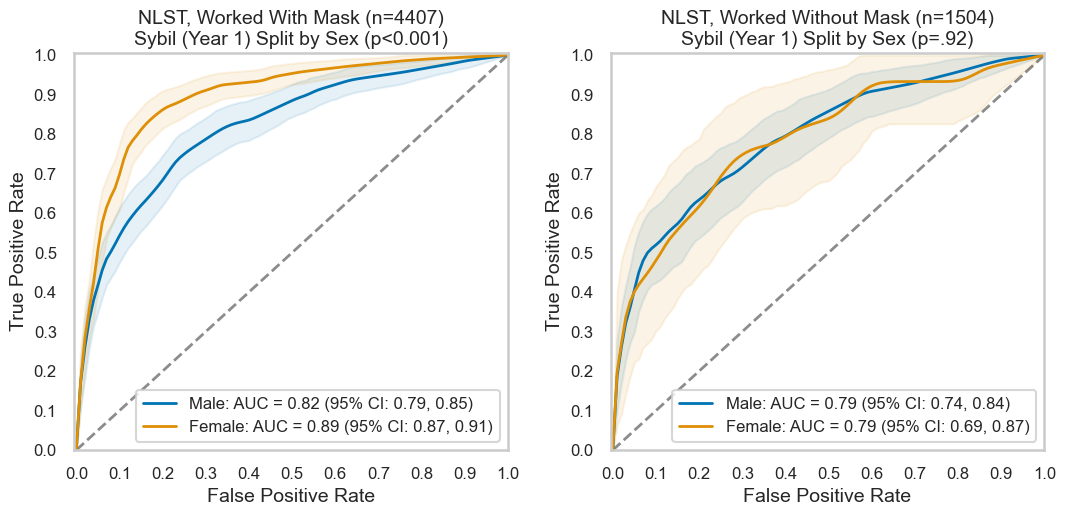

In [58]:
_ = roc.plot_rocs_isolate_confounder(
    nlst_5911,
    'Sex',
    'Work w/o Mask',
    models={'Sybil (Year 1)': 'sybil_year1'},
    dataset_name="NLST",
    num_bootstraps=1000,
    imgpath=f"{FIG_DIR}/sybilROCgender-WrkNoMask.png"
)

### Race

In [59]:
cat_race_confounders, num_race_confounders = output.confounders_by_attribute(nlst_5911_v2, 'WhiteOrBlack', NLST_POSSIBLE_CONFOUNDERS, precision=1)
num_race_confounders

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:560: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]


White Mal     White Ben  \
Category     Confounder             Subset                                     
Demographics Age                    Mean (SD)       64.1 (5.2)    63.1 (5.3)   
                                    Median (IQR)        64 (8)        62 (8)   
             Body Mass Index        Mean (SD)       26.9 (4.4)    27.6 (4.9)   
                                    Median (IQR)        26 (4)        27 (6)   
             Height                 Mean (SD)       68.0 (3.9)    68.0 (4.0)   
                                    Median (IQR)        68 (6)        68 (6)   
             Weight                 Mean (SD)     177.4 (36.6)  182.7 (39.1)   
                                    Median (IQR)      176 (50)      180 (51)   
Other        Diameter (mm)          Mean (SD)       14.4 (9.4)     8.4 (5.1)   
                                    Median (IQR)        12 (8)         6 (4)   
             Nodules Per Scan       Mean (SD)        2.3 (1.3)     1.9 (1.2)   
                                    Median (IQR)         2 (2)         1 (1)   
Smoking      Age at Smoking Onset   Mean (SD)       16.2 (3.5)    16.5 (3.5)   
                                    Median (IQR)        16 (4)        16 (3)   
             Cigarettes per Day     Mean (SD)      30.9 (12.9)   28.6 (11.5)   
                                    Median (IQR)       30 (20)       25 (15)   
             Pack-Years             Mean (SD)      66.8 (30.2)   57.7 (24.2)   
                                    Median (IQR)       57 (39)       51 (29)   
             Total Years of Smoking Mean (SD)       43.5 (7.2)    40.9 (7.4)   
                                    Median (IQR)       44 (10)       41 (10)   

                                                     Black Mal     Black Ben  \
Category     Confounder             Subset                                     
Demographics Age                    Mean (SD)       63.0 (4.0)    62.6 (5.1)   
                                    Median (IQR)        63 (7)        62 (8)   
             Body Mass Index        Mean (SD)       27.2 (3.8)    28.5 (6.0)   
                                    Median (IQR)        25 (5)        28 (6)   
             Height                 Mean (SD)       67.0 (4.4)    67.7 (3.9)   
                                    Median (IQR)        66 (7)        67 (7)   
             Weight                 Mean (SD)     173.5 (30.2)  185.5 (42.8)   
                                    Median (IQR)      165 (39)      183 (47)   
Other        Diameter (mm)          Mean (SD)      14.7 (10.4)     9.0 (5.5)   
                                    Median (IQR)       12 (10)         6 (5)   
             Nodules Per Scan       Mean (SD)        2.2 (1.1)     1.7 (1.1)   
                                    Median (IQR)         2 (2)         1 (1)   
Smoking      Age at Smoking Onset   Mean (SD)       17.7 (3.4)    17.1 (3.5)   
                                    Median (IQR)        17 (4)        17 (4)   
             Cigarettes per Day     Mean (SD)       23.9 (7.7)    23.0 (8.0)   
                                    Median (IQR)       20 (10)        20 (4)   
             Pack-Years             Mean (SD)      51.2 (19.2)   48.1 (18.5)   
                                    Median (IQR)       48 (16)       42 (18)   
             Total Years of Smoking Mean (SD)       42.7 (5.7)    42.0 (6.8)   
                                    Median (IQR)       43 (11)        42 (9)   

                                                  Difference  
Category     Confounder             Subset                    
Demographics Age                    Mean (SD)         0.5507  
                                    Median (IQR)     -0.5000  
             Body Mass Index        Mean (SD)        -0.7176  
                                    Median (IQR)     -0.7401  
             Height                 Mean (SD)         0.4392  
                                    Median (IQR)      1.0000  
             Weight        

In [60]:
num_race_confounders

White Mal     White Ben  \
Category     Confounder             Subset                                     
Demographics Age                    Mean (SD)       64.1 (5.2)    63.1 (5.3)   
                                    Median (IQR)        64 (8)        62 (8)   
             Body Mass Index        Mean (SD)       26.9 (4.4)    27.6 (4.9)   
                                    Median (IQR)        26 (4)        27 (6)   
             Height                 Mean (SD)       68.0 (3.9)    68.0 (4.0)   
                                    Median (IQR)        68 (6)        68 (6)   
             Weight                 Mean (SD)     177.4 (36.6)  182.7 (39.1)   
                                    Median (IQR)      176 (50)      180 (51)   
Other        Diameter (mm)          Mean (SD)       14.4 (9.4)     8.4 (5.1)   
                                    Median (IQR)        12 (8)         6 (4)   
             Nodules Per Scan       Mean (SD)        2.3 (1.3)     1.9 (1.2)   
                                    Median (IQR)         2 (2)         1 (1)   
Smoking      Age at Smoking Onset   Mean (SD)       16.2 (3.5)    16.5 (3.5)   
                                    Median (IQR)        16 (4)        16 (3)   
             Cigarettes per Day     Mean (SD)      30.9 (12.9)   28.6 (11.5)   
                                    Median (IQR)       30 (20)       25 (15)   
             Pack-Years             Mean (SD)      66.8 (30.2)   57.7 (24.2)   
                                    Median (IQR)       57 (39)       51 (29)   
             Total Years of Smoking Mean (SD)       43.5 (7.2)    40.9 (7.4)   
                                    Median (IQR)       44 (10)       41 (10)   

                                                     Black Mal     Black Ben  \
Category     Confounder             Subset                                     
Demographics Age                    Mean (SD)       63.0 (4.0)    62.6 (5.1)   
                                    Median (IQR)        63 (7)        62 (8)   
             Body Mass Index        Mean (SD)       27.2 (3.8)    28.5 (6.0)   
                                    Median (IQR)        25 (5)        28 (6)   
             Height                 Mean (SD)       67.0 (4.4)    67.7 (3.9)   
                                    Median (IQR)        66 (7)        67 (7)   
             Weight                 Mean (SD)     173.5 (30.2)  185.5 (42.8)   
                                    Median (IQR)      165 (39)      183 (47)   
Other        Diameter (mm)          Mean (SD)      14.7 (10.4)     9.0 (5.5)   
                                    Median (IQR)       12 (10)         6 (5)   
             Nodules Per Scan       Mean (SD)        2.2 (1.1)     1.7 (1.1)   
                                    Median (IQR)         2 (2)         1 (1)   
Smoking      Age at Smoking Onset   Mean (SD)       17.7 (3.4)    17.1 (3.5)   
                                    Median (IQR)        17 (4)        17 (4)   
             Cigarettes per Day     Mean (SD)       23.9 (7.7)    23.0 (8.0)   
                                    Median (IQR)       20 (10)        20 (4)   
             Pack-Years             Mean (SD)      51.2 (19.2)   48.1 (18.5)   
                                    Median (IQR)       48 (16)       42 (18)   
             Total Years of Smoking Mean (SD)       42.7 (5.7)    42.0 (6.8)   
                                    Median (IQR)       43 (11)        42 (9)   

                                                  Difference  
Category     Confounder             Subset                    
Demographics Age                    Mean (SD)         0.5507  
                                    Median (IQR)     -0.5000  
             Body Mass Index        Mean (SD)        -0.7176  
                                    Median (IQR)     -0.7401  
             Height                 Mean (SD)         0.4392  
                                    Median (IQR)      1.0000  
             Weight        

In [61]:
nlst_preds_nodule.groupby(['WhiteOrBlack'])[['NoduleType', 'label']].value_counts(dropna=True, normalize=True)

WhiteOrBlack  NoduleType          label
1.0           Solid               0        0.555186
              GroundGlassOpacity  0        0.220346
              SemiSolid           0        0.089362
              Perifissural        0        0.058444
              Solid               1        0.052859
              PartSolid           1        0.015160
              NonSolid            1        0.008112
              Calcified           0        0.000532
2.0           Solid               0        0.471933
              GroundGlassOpacity  0        0.255717
              SemiSolid           0        0.116424
              Solid               1        0.101871
              Perifissural        0        0.037422
              PartSolid           1        0.010395
              NonSolid            1        0.006237
Name: proportion, dtype: float64

In [62]:
cat_race_confounders.xs("Nodule")

White               Black              Difference  \
                              Mal   Ben Total %   Mal  Ben Total %              
Confounder           Subset                                                     
Calcified Nodule     False    530  4988    99.9    28  160   100.0    -0.0905   
                     True       0     5     0.1     0    0     0.0     0.0905   
Ground-Glass Nodule  False    530  3483    72.7    28  100    68.1     4.5747   
                     True       0  1510    27.3     0   60    31.9    -4.5747   
Nodule in Upper Lung False    206  2461    48.3    13   77    47.9     0.4167   
                     True     324  2532    51.7    15   83    52.1    -0.4167   
Non-Solid Nodule     False    480  4993    99.1    26  160    98.9     0.1585   
                     True      50     0     0.9     2    0     1.1    -0.1585   
Part-Solid Nodule    False    437  4993    98.3    24  160    97.9     0.4438   
                     True      93     0     1.7     4    0     2.1    -0.4438   
Perfissural Nodule   False    530  4495    91.0    28  145    92.0    -1.0381   
                     True       0   498     9.0     0   15     8.0     1.0381   
Semi-Solid Nodule    False    530  4303    87.5    28  131    84.6     2.9323   
                     True       0   690    12.5     0   29    15.4    -2.9323   
Solid Nodule         False    133  1614    31.6     5   69    39.4    -7.7303   
                     True     397  3379    68.4    23   91    60.6     7.7303   
Spiculated Nodule    False    520  4992    99.8    28  160   100.0    -0.1992   
                     True      10     1     0.2     0    0     0.0     0.1992   

                            Abs Diff  
                                      
Confounder           Subset           
Calcified Nodule     False    0.0905  
                     True     0.0905  
Ground-Glass Nodule  False    4.5747  
                     True     4.5747  
Nodule in Upper Lung False    0.4167  
                     True     0.4167  
Non-Solid Nodule     False    0.1585  
                     True     0.1585  
Part-Solid Nodule    False    0.4438  
                     True     0.4438  
Perfissural Nodule   False    1.0381  
                     True     1.0381  
Semi-Solid Nodule    False    2.9323  
                     True     2.9323  
Solid Nodule         False    7.7303  
                     True     7.7303  
Spiculated Nodule    False    0.1992  
                     True     0.1992

In [63]:
race_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-race-by-factors-nlst-5911.csv', index_col=0)
race_prev_roc, race_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'WhiteOrBlack',
    NLST_POSSIBLE_CONFOUNDERS,
    race_roc,
    'Venkadesh21',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(race_prev_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/raceIsolationPlusROC.tex",
    hrules=True, label='tab:raceIsolationPlusROC', environment='sidewaystable*', column_format=f'll|rrrr|rrrr|l', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between White and Black participants, and the AUROC scores of the Venkadesh21 model between these racial groups isolating for them.'))

race_prev_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:560: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:579: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df2 = df2.drop(columns=["Difference", "Abs Diff"]).droplevel(0)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:589: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

White                                  Black       \
                              Mal   Ben Total %              AUROC   Mal  Ben   
Confounder           Subset                                                     
Cigarettes per Day   ≤ 25     246  2610    51.7  0.88 (0.86, 0.90)    20  127   
                     > 25     284  2383    48.3  0.90 (0.89, 0.92)     8   33   
Pack-Years           ≤ 55     249  2877    56.6  0.88 (0.86, 0.90)    23  125   
                     > 55     281  2116    43.4  0.90 (0.88, 0.91)     5   35   
Hypertension Diag.   True     196  1617    32.8  0.87 (0.84, 0.90)    16   86   
                     False    329  3373    67.0  0.90 (0.89, 0.92)    12   74   
Current Smoker       False    247  2542    50.5  0.89 (0.87, 0.91)    11   48   
                     True     283  2451    49.5  0.89 (0.87, 0.91)    17  112   
Smoked Pipe          True     132  1127    22.8  0.90 (0.87, 0.92)     5   12   
                     False    397  3837    76.7  0.89 (0.87, 0.91)    23  145   
Sex                  Female   218  2084    41.7  0.89 (0.87, 0.91)    15   88   
                     Male     312  2909    58.3  0.89 (0.87, 0.91)    13   72   
Diabetes Diag.       True      50   412     8.4  0.90 (0.86, 0.94)     4   31   
                     False    480  4578    91.6  0.89 (0.88, 0.90)    24  129   
Height               > 68     248  2389    47.7  0.89 (0.87, 0.91)    11   60   
                     ≤ 68     282  2604    52.3  0.89 (0.87, 0.91)    17  100   
Work - Farming       False    485  4358    87.7  0.89 (0.88, 0.91)    26  156   
                     True      45   635    12.3  0.90 (0.85, 0.94)     2    4   
Age at Smoking Onset ≤ 16     320  2735    55.3  0.89 (0.87, 0.91)    10   79   
                     > 16     210  2258    44.7  0.90 (0.87, 0.92)    18   81   

                                                          p  
                            Total %              AUROC       
Confounder           Subset                                  
Cigarettes per Day   ≤ 25      78.2  0.77 (0.67, 0.87)  .08  
                     > 25      21.8  0.94 (0.85, 1.00)  .50  
Pack-Years           ≤ 55      78.7  0.79 (0.69, 0.88)  .10  
                     > 55      21.3  0.93 (0.83, 1.00)  .63  
Hypertension Diag.   True      54.3  0.73 (0.61, 0.85)  .04  
                     False     45.7  0.93 (0.87, 0.98)  .60  
Current Smoker       False     31.4  0.88 (0.77, 0.96)  .80  
                     True      68.6  0.76 (0.62, 0.88)  .05  
Smoked Pipe          True       9.0  0.93 (0.77, 1.00)  .75  
                     False     89.4  0.80 (0.70, 0.89)  .11  
Sex                  Female    54.8  0.84 (0.75, 0.92)  .40  
                     Male      45.2  0.81 (0.66, 0.93)  .24  
Diabetes Diag.       True      18.6  0.67 (0.32, 1.00)  .11  
                     False     81.4  0.83 (0.74, 0.91)  .26  
Height               > 68      37.8  0.78 (0.61, 0.93)  .19  
                     ≤ 68      62.2  0.84 (0.76, 0.92)  .36  
Work - Farming       False     96.8  0.81 (0.71, 0.88)  .09  
                     True       3.2  0.99 (1.00, 1.00)  .05  
Age at Smoking Onset ≤ 16      47.3  0.88 (0.80, 0.95)  .90  
                     > 16      52.7  0.78 (0.66, 0.89)  .07

In [64]:
race_roc_all = output.roc_isolations_pretty(
        race_roc, 'WhiteOrBlack', 'Venkadesh21', precision=2
)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:589: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_1_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:592: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_2_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [65]:
race_roc_all.xs('Nodule')

White              Black    p
                                         AUROC              AUROC     
Confounder           Subset                                           
Solid Nodule         False   0.88 (0.84, 0.91)  0.60 (0.30, 0.89)  .03
                     True    0.90 (0.88, 0.91)  0.87 (0.80, 0.94)  .62
Ground-Glass Nodule  False   0.89 (0.87, 0.90)  0.82 (0.73, 0.90)  .16
Perfissural Nodule   False   0.89 (0.87, 0.90)  0.81 (0.72, 0.88)  .09
Non-Solid Nodule     False   0.90 (0.89, 0.92)  0.86 (0.79, 0.91)  .35
Part-Solid Nodule    False   0.89 (0.87, 0.90)  0.82 (0.74, 0.90)  .24
Semi-Solid Nodule    False   0.91 (0.89, 0.92)  0.86 (0.78, 0.93)  .31
Calcified Nodule     False   0.89 (0.88, 0.91)  0.82 (0.74, 0.89)  .14
Nodule in Upper Lung False   0.93 (0.92, 0.95)  0.91 (0.79, 0.98)  .65
                     True    0.85 (0.83, 0.87)  0.70 (0.56, 0.82)  .03
Spiculated Nodule    False   0.89 (0.88, 0.90)  0.82 (0.74, 0.89)  .15

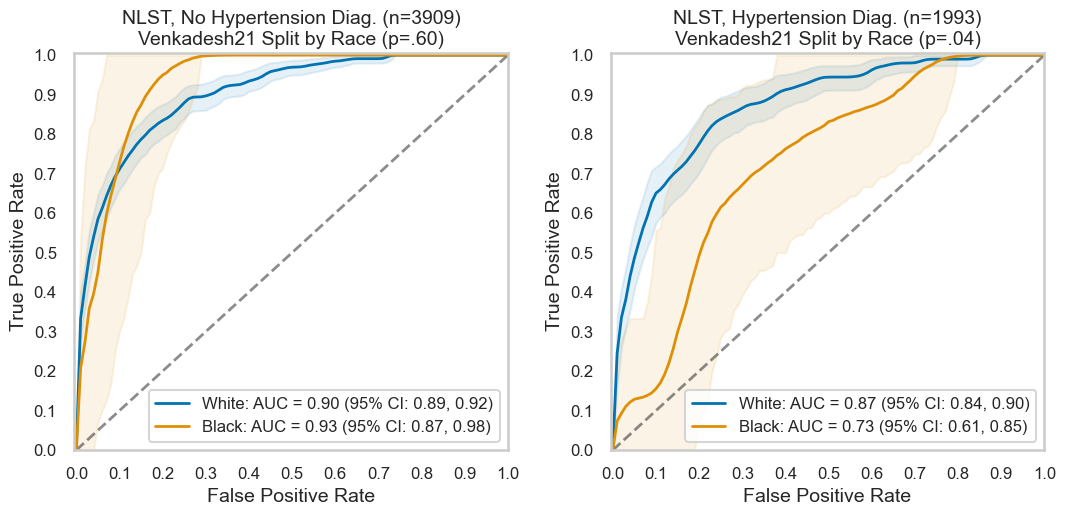

In [66]:
_ = roc.plot_rocs_isolate_confounder(
    nlst_5911,
    'Race',
    'Hypertension Diag.',
    models={'Venkadesh21': 'DL_cal'},
    dataset_name="NLST",
    num_bootstraps=1000,
    imgpath=f"{FIG_DIR}/venkROCrace-Hypertension.png"
)

### BMI

In [67]:
bmi_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-bmi-by-factors-nlst-5911.csv', index_col=0)
bmi_prev_roc, bmi_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'Overweight',
    NLST_POSSIBLE_CONFOUNDERS,
    bmi_roc,
    'Sybil (Year 1)',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(bmi_prev_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiIsolationPlusROC.tex",
    hrules=True, label='tab:bmiIsolationPlusROC', environment='sidewaystable*', column_format=f'll|rrrr|rrrr|l', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between high and low BMI participants, and the AUROC scores of the Sybil (Year 1) model between BMI groups isolating for them.'))

bmi_prev_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:560: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:589: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_1_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:592: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

< 25                                  ≥ 25  \
                               Mal   Ben Total %              AUROC  Mal   
Confounder             Subset                                              
Weight                 > 180    10    90     5.3  0.93 (0.83, 0.99)  237   
                       ≤ 180   199  1600    94.7  0.81 (0.78, 0.84)  135   
Current Smoker         False    74   642    37.7  0.82 (0.76, 0.87)  193   
                       True    135  1048    62.3  0.81 (0.77, 0.86)  179   
Sex                    Female  117   879    52.4  0.85 (0.81, 0.89)  127   
                       Male     92   811    47.6  0.76 (0.70, 0.82)  245   
Emphysema in Scan      True    103   789    47.0  0.78 (0.73, 0.83)  161   
                       False   106   901    53.0  0.84 (0.79, 0.89)  211   
Hypertension Diag.     True     62   397    24.2  0.80 (0.73, 0.86)  161   
                       False   143  1292    75.6  0.82 (0.78, 0.85)  209   
Height                 > 68     71   680    39.5  0.77 (0.70, 0.83)  196   
                       ≤ 68    138  1010    60.5  0.84 (0.81, 0.88)  176   
Total Years of Smoking > 40    142   983    59.2  0.79 (0.75, 0.84)  248   
                       ≤ 40     67   707    40.8  0.85 (0.80, 0.90)  124   
Smoked Pipe            False   174  1403    83.0  0.83 (0.80, 0.87)  262   
                       True     34   280    16.5  0.74 (0.63, 0.84)  109   
Diabetes Diag.         True      6    62     3.6  0.99 (1.00, 1.00)   51   
                       False   202  1625    96.2  0.81 (0.77, 0.84)  321   
Smoked Cigars          False   181  1446    85.7  0.83 (0.80, 0.87)  289   
                       True     27   238    14.0  0.70 (0.59, 0.81)   82   

                                                                     p  
                                Ben Total %              AUROC          
Confounder             Subset                                           
Weight                 > 180   2479    67.7  0.84 (0.81, 0.87)     .12  
                       ≤ 180   1161    32.3  0.89 (0.86, 0.92)    .002  
Current Smoker         False   2021    55.2  0.85 (0.82, 0.88)     .30  
                       True    1619    44.8  0.86 (0.84, 0.89)     .07  
Sex                    Female  1347    36.7  0.90 (0.87, 0.93)     .11  
                       Male    2293    63.3  0.83 (0.80, 0.86)     .03  
Emphysema in Scan      True    1103    31.5  0.81 (0.77, 0.85)     .44  
                       False   2537    68.5  0.88 (0.86, 0.91)     .10  
Hypertension Diag.     True    1373    38.2  0.82 (0.79, 0.85)     .55  
                       False   2265    61.7  0.88 (0.85, 0.90)     .02  
Height                 > 68    1820    50.2  0.82 (0.78, 0.85)     .19  
                       ≤ 68    1820    49.8  0.89 (0.87, 0.92)     .04  
Total Years of Smoking > 40    1782    50.6  0.86 (0.84, 0.88)    .009  
                       ≤ 40    1858    49.4  0.84 (0.80, 0.88)     .69  
Smoked Pipe            False   2736    74.7  0.86 (0.84, 0.89)     .15  
                       True     878    24.6  0.83 (0.79, 0.87)     .09  
Diabetes Diag.         True     426    11.9  0.82 (0.75, 0.88)  < .001  
                       False   3214    88.1  0.86 (0.84, 0.88)     .01  
Smoked Cigars          False   2822    77.5  0.86 (0.83, 0.89)     .23  
                       True     801    22.0  0.83 (0.79, 0.88)     .02

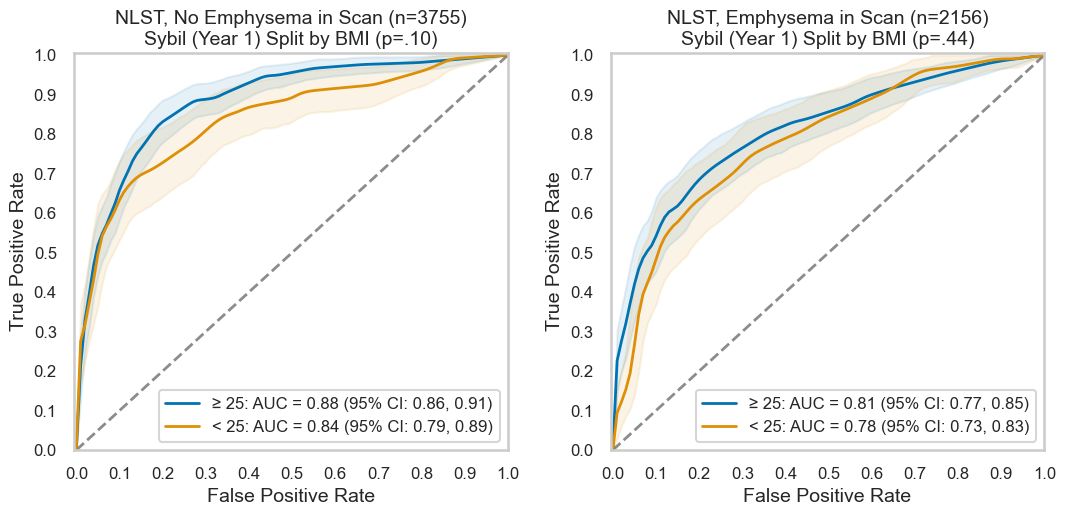

In [68]:
_ = roc.plot_rocs_isolate_confounder(
    nlst_5911,
    'BMI',
    'Emphysema in Scan',
    models={'Sybil (Year 1)': 'sybil_year1'},
    dataset_name="NLST",
    num_bootstraps=1000,
    imgpath=f"{FIG_DIR}/sybilROCbmi-Emphysema.png"
)

In [69]:
bmi_pancan_roc, bmi_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'Overweight',
    NLST_POSSIBLE_CONFOUNDERS,
    bmi_roc,
    'PanCan2b',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(bmi_pancan_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiIsolationPlusROCpancan.tex",
    hrules=True, label='tab:bmiIsolationPlusROCpancan', environment='sidewaystable*', column_format=f'll|rrrr|rrrr|l', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between high and low BMI participants, and the AUROC scores of the PanCan2b model between BMI groups isolating for them.'))

bmi_pancan_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:560: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:589: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_1_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:592: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

< 25                                  ≥ 25  \
                               Mal   Ben Total %              AUROC  Mal   
Confounder             Subset                                              
Weight                 > 180    10    90     5.3  0.85 (0.68, 0.99)  237   
                       ≤ 180   199  1600    94.7  0.73 (0.69, 0.76)  135   
Current Smoker         False    74   642    37.7  0.76 (0.70, 0.82)  193   
                       True    135  1048    62.3  0.72 (0.67, 0.77)  179   
Sex                    Female  117   879    52.4  0.74 (0.69, 0.79)  127   
                       Male     92   811    47.6  0.73 (0.67, 0.78)  245   
Emphysema in Scan      True    103   789    47.0  0.68 (0.62, 0.73)  161   
                       False   106   901    53.0  0.78 (0.74, 0.83)  211   
Hypertension Diag.     True     62   397    24.2  0.70 (0.63, 0.77)  161   
                       False   143  1292    75.6  0.74 (0.70, 0.78)  209   
Height                 > 68     71   680    39.5  0.70 (0.64, 0.77)  196   
                       ≤ 68    138  1010    60.5  0.75 (0.71, 0.79)  176   
Total Years of Smoking > 40    142   983    59.2  0.69 (0.64, 0.74)  248   
                       ≤ 40     67   707    40.8  0.80 (0.74, 0.86)  124   
Smoked Pipe            False   174  1403    83.0  0.73 (0.69, 0.77)  262   
                       True     34   280    16.5  0.72 (0.63, 0.81)  109   
Diabetes Diag.         True      6    62     3.6  0.96 (0.91, 1.00)   51   
                       False   202  1625    96.2  0.72 (0.69, 0.76)  321   
Smoked Cigars          False   181  1446    85.7  0.74 (0.70, 0.78)  289   
                       True     27   238    14.0  0.66 (0.55, 0.77)   82   

                                                                     p  
                                Ben Total %              AUROC          
Confounder             Subset                                           
Weight                 > 180   2479    67.7  0.80 (0.77, 0.83)     .46  
                       ≤ 180   1161    32.3  0.82 (0.79, 0.85)  < .001  
Current Smoker         False   2021    55.2  0.80 (0.77, 0.83)     .24  
                       True    1619    44.8  0.81 (0.78, 0.84)    .002  
Sex                    Female  1347    36.7  0.81 (0.78, 0.85)     .02  
                       Male    2293    63.3  0.81 (0.79, 0.84)     .01  
Emphysema in Scan      True    1103    31.5  0.80 (0.76, 0.83)  < .001  
                       False   2537    68.5  0.81 (0.78, 0.83)     .43  
Hypertension Diag.     True    1373    38.2  0.78 (0.74, 0.82)     .05  
                       False   2265    61.7  0.82 (0.80, 0.85)    .005  
Height                 > 68    1820    50.2  0.81 (0.78, 0.84)    .004  
                       ≤ 68    1820    49.8  0.81 (0.78, 0.84)     .05  
Total Years of Smoking > 40    1782    50.6  0.79 (0.76, 0.82)  < .001  
                       ≤ 40    1858    49.4  0.82 (0.79, 0.85)     .56  
Smoked Pipe            False   2736    74.7  0.81 (0.79, 0.84)    .002  
                       True     878    24.6  0.80 (0.76, 0.84)     .16  
Diabetes Diag.         True     426    11.9  0.85 (0.80, 0.90)     .06  
                       False   3214    88.1  0.80 (0.78, 0.83)    .001  
Smoked Cigars          False   2822    77.5  0.80 (0.78, 0.83)     .01  
                       True     801    22.0  0.83 (0.79, 0.87)    .008

### Education

In [70]:
hs_or_more_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-hs-or-more-by-factors-nlst-5911.csv', index_col=0)
hs_or_more_sybil_roc, hs_or_more_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'HS-or-more',
    NLST_POSSIBLE_CONFOUNDERS,
    hs_or_more_roc,
    'Sybil (Year 1)',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)
hs_or_more_sybil_roc

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:560: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:589: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_1_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:592: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

< HS                                 ≥ HS        \
                               Mal  Ben Total %              AUROC  Mal   Ben   
Confounder             Subset                                                   
Age at Smoking Onset   ≤ 16     30  291    80.0  0.82 (0.73, 0.91)  309  2580   
                       > 16     11   69    20.0  0.81 (0.66, 0.95)  217  2293   
Total Years of Smoking ≤ 40     10   87    24.2  0.68 (0.47, 0.86)  173  2435   
                       > 40     31  273    75.8  0.87 (0.79, 0.93)  353  2438   
Work w/o Mask          True     14  158    42.9  0.80 (0.65, 0.94)  123  1189   
                       False    27  202    57.1  0.83 (0.74, 0.92)  403  3684   
Age                    > 61     26  257    70.6  0.87 (0.78, 0.94)  326  2646   
                       ≤ 61     15  103    29.4  0.76 (0.62, 0.88)  200  2227   
Pack-Years             ≤ 55     24  167    47.6  0.80 (0.70, 0.90)  254  2866   
                       > 55     17  193    52.4  0.87 (0.75, 0.97)  272  2007   
Worked w/ Smoker       True     34  283    79.1  0.82 (0.72, 0.90)  467  4272   
                       False     6   73    19.7  0.92 (0.82, 0.99)   57   561   
Sex                    Female   14  121    33.7  0.90 (0.81, 0.97)  227  2059   
                       Male     27  239    66.3  0.78 (0.68, 0.88)  299  2814   
Work - Welding         False    36  308    85.8  0.81 (0.72, 0.89)  491  4608   
                       True      5   52    14.2  0.89 (0.74, 0.99)   35   265   
Diameter (mm)          > 6      39  247    71.3  0.80 (0.72, 0.87)  473  2917   
                       ≤ 6       2  113    28.7  0.71 (0.43, 0.95)   53  1956   
Current Smoker         False    21  146    41.6  0.77 (0.64, 0.87)  238  2469   
                       True     20  214    58.4  0.88 (0.79, 0.95)  288  2404   

                                                            p  
                              Total %              AUROC       
Confounder             Subset                                  
Age at Smoking Onset   ≤ 16      53.5  0.85 (0.82, 0.87)  .61  
                       > 16      46.5  0.85 (0.81, 0.88)  .67  
Total Years of Smoking ≤ 40      48.3  0.85 (0.82, 0.88)  .06  
                       > 40      51.7  0.84 (0.81, 0.86)  .45  
Work w/o Mask          True      24.3  0.80 (0.75, 0.84)  .99  
                       False     75.7  0.86 (0.84, 0.88)  .58  
Age                    > 61      55.0  0.84 (0.81, 0.86)  .52  
                       ≤ 61      45.0  0.86 (0.83, 0.88)  .18  
Pack-Years             ≤ 55      57.8  0.85 (0.82, 0.87)  .46  
                       > 55      42.2  0.84 (0.82, 0.87)  .66  
Worked w/ Smoker       True      87.8  0.85 (0.83, 0.87)  .43  
                       False     11.4  0.82 (0.75, 0.88)  .25  
Sex                    Female    42.3  0.88 (0.85, 0.90)  .70  
                       Male      57.7  0.82 (0.79, 0.84)  .50  
Work - Welding         False     94.4  0.85 (0.83, 0.87)  .39  
                       True       5.6  0.79 (0.70, 0.86)  .35  
Diameter (mm)          > 6       62.8  0.83 (0.81, 0.85)  .47  
                       ≤ 6       37.2  0.71 (0.62, 0.79)  .98  
Current Smoker         False     50.1  0.85 (0.83, 0.88)  .15  
                       True      49.9  0.84 (0.81, 0.87)  .49

In [71]:
hs_or_more_venk21_roc, hs_or_more_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'HS-or-more',
    NLST_POSSIBLE_CONFOUNDERS,
    hs_or_more_roc,
    'Venkadesh21',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)
hs_or_more_venk21_roc

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:560: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:589: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_1_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:592: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

< HS                                 ≥ HS        \
                               Mal  Ben Total %              AUROC  Mal   Ben   
Confounder             Subset                                                   
Age at Smoking Onset   ≤ 16     30  291    80.0  0.86 (0.78, 0.93)  309  2580   
                       > 16     11   69    20.0  0.82 (0.60, 0.98)  217  2293   
Total Years of Smoking ≤ 40     10   87    24.2  0.83 (0.69, 0.95)  173  2435   
                       > 40     31  273    75.8  0.86 (0.77, 0.94)  353  2438   
Work w/o Mask          True     14  158    42.9  0.78 (0.60, 0.95)  123  1189   
                       False    27  202    57.1  0.89 (0.82, 0.94)  403  3684   
Age                    > 61     26  257    70.6  0.84 (0.72, 0.94)  326  2646   
                       ≤ 61     15  103    29.4  0.89 (0.79, 0.97)  200  2227   
Pack-Years             ≤ 55     24  167    47.6  0.85 (0.74, 0.94)  254  2866   
                       > 55     17  193    52.4  0.86 (0.73, 0.98)  272  2007   
Worked w/ Smoker       True     34  283    79.1  0.87 (0.79, 0.94)  467  4272   
                       False     6   73    19.7  0.80 (0.63, 0.97)   57   561   
Sex                    Female   14  121    33.7  0.94 (0.84, 0.99)  227  2059   
                       Male     27  239    66.3  0.82 (0.71, 0.91)  299  2814   
Work - Welding         False    36  308    85.8  0.85 (0.76, 0.92)  491  4608   
                       True      5   52    14.2  0.95 (0.87, 1.00)   35   265   
Diameter (mm)          > 6      39  247    71.3  0.84 (0.76, 0.91)  473  2917   
                       ≤ 6       2  113    28.7  0.65 (0.26, 0.99)   53  1956   
Current Smoker         False    21  146    41.6  0.79 (0.68, 0.90)  238  2469   
                       True     20  214    58.4  0.90 (0.78, 0.99)  288  2404   

                                                            p  
                              Total %              AUROC       
Confounder             Subset                                  
Age at Smoking Onset   ≤ 16      53.5  0.89 (0.88, 0.91)  .48  
                       > 16      46.5  0.89 (0.87, 0.91)  .35  
Total Years of Smoking ≤ 40      48.3  0.89 (0.87, 0.92)  .44  
                       > 40      51.7  0.89 (0.87, 0.91)  .49  
Work w/o Mask          True      24.3  0.90 (0.87, 0.92)  .11  
                       False     75.7  0.89 (0.87, 0.91)  .97  
Age                    > 61      55.0  0.88 (0.86, 0.90)  .39  
                       ≤ 61      45.0  0.90 (0.88, 0.92)  .83  
Pack-Years             ≤ 55      57.8  0.88 (0.86, 0.90)  .48  
                       > 55      42.2  0.90 (0.88, 0.92)  .53  
Worked w/ Smoker       True      87.8  0.90 (0.88, 0.91)  .56  
                       False     11.4  0.86 (0.81, 0.92)  .58  
Sex                    Female    42.3  0.89 (0.86, 0.91)  .30  
                       Male      57.7  0.90 (0.88, 0.91)  .12  
Work - Welding         False     94.4  0.89 (0.88, 0.91)  .27  
                       True       5.6  0.90 (0.85, 0.95)  .49  
Diameter (mm)          > 6       62.8  0.87 (0.85, 0.89)  .47  
                       ≤ 6       37.2  0.90 (0.86, 0.93)  .24  
Current Smoker         False     50.1  0.90 (0.88, 0.92)  .06  
                       True      49.9  0.88 (0.86, 0.90)  .67

In [72]:
hs_or_more_pancan_roc, hs_or_more_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'HS-or-more',
    NLST_POSSIBLE_CONFOUNDERS,
    hs_or_more_roc,
    'PanCan2b',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(hs_or_more_pancan_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/educationIsolationPlusROCpancan.tex",
    hrules=True, label='tab:educationIsolationPlusROCpancan', environment='sidewaystable*', column_format=f'll|rrrr|rrrr|l', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between have graduated high school or higher and those who have not, and the AUROC scores of the PanCan2b model between these subgroups isolating for them.'))


hs_or_more_pancan_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:560: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:589: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_1_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:592: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

< HS                                 ≥ HS        \
                               Mal  Ben Total %              AUROC  Mal   Ben   
Confounder             Subset                                                   
Age at Smoking Onset   ≤ 16     30  291    80.0  0.78 (0.69, 0.86)  309  2580   
                       > 16     11   69    20.0  0.78 (0.62, 0.92)  217  2293   
Total Years of Smoking ≤ 40     10   87    24.2  0.70 (0.49, 0.88)  173  2435   
                       > 40     31  273    75.8  0.81 (0.73, 0.87)  353  2438   
Work w/o Mask          True     14  158    42.9  0.70 (0.55, 0.85)  123  1189   
                       False    27  202    57.1  0.83 (0.75, 0.91)  403  3684   
Age                    > 61     26  257    70.6  0.81 (0.71, 0.88)  326  2646   
                       ≤ 61     15  103    29.4  0.77 (0.63, 0.88)  200  2227   
Pack-Years             ≤ 55     24  167    47.6  0.75 (0.65, 0.84)  254  2866   
                       > 55     17  193    52.4  0.83 (0.70, 0.92)  272  2007   
Worked w/ Smoker       True     34  283    79.1  0.76 (0.67, 0.83)  467  4272   
                       False     6   73    19.7  0.92 (0.85, 0.97)   57   561   
Sex                    Female   14  121    33.7  0.81 (0.68, 0.92)  227  2059   
                       Male     27  239    66.3  0.78 (0.69, 0.86)  299  2814   
Work - Welding         False    36  308    85.8  0.79 (0.71, 0.86)  491  4608   
                       True      5   52    14.2  0.76 (0.48, 1.00)   35   265   
Diameter (mm)          > 6      39  247    71.3  0.74 (0.66, 0.81)  473  2917   
                       ≤ 6       2  113    28.7  0.54 (0.15, 0.91)   53  1956   
Current Smoker         False    21  146    41.6  0.72 (0.58, 0.83)  238  2469   
                       True     20  214    58.4  0.84 (0.76, 0.91)  288  2404   

                                                            p  
                              Total %              AUROC       
Confounder             Subset                                  
Age at Smoking Onset   ≤ 16      53.5  0.77 (0.74, 0.79)  .91  
                       > 16      46.5  0.81 (0.78, 0.83)  .72  
Total Years of Smoking ≤ 40      48.3  0.83 (0.80, 0.85)  .15  
                       > 40      51.7  0.75 (0.73, 0.78)  .24  
Work w/o Mask          True      24.3  0.77 (0.73, 0.82)  .38  
                       False     75.7  0.79 (0.77, 0.81)  .35  
Age                    > 61      55.0  0.76 (0.73, 0.78)  .36  
                       ≤ 61      45.0  0.81 (0.78, 0.84)  .51  
Pack-Years             ≤ 55      57.8  0.81 (0.78, 0.83)  .32  
                       > 55      42.2  0.76 (0.73, 0.79)  .30  
Worked w/ Smoker       True      87.8  0.79 (0.77, 0.81)  .52  
                       False     11.4  0.76 (0.70, 0.82)  .07  
Sex                    Female    42.3  0.78 (0.75, 0.81)  .70  
                       Male      57.7  0.79 (0.77, 0.82)  .79  
Work - Welding         False     94.4  0.78 (0.76, 0.80)  .91  
                       True       5.6  0.83 (0.75, 0.89)  .59  
Diameter (mm)          > 6       62.8  0.73 (0.71, 0.75)  .90  
                       ≤ 6       37.2  0.66 (0.59, 0.73)  .56  
Current Smoker         False     50.1  0.80 (0.77, 0.83)  .18  
                       True      49.9  0.77 (0.74, 0.80)  .19

## Sensitivity and Specificity

### Sex

#### Sybil

In [73]:
gender_pairwise_comps = None

In [74]:
gender_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-gender-by-factors-nlst-5911.csv', index_col=0)
gender_tpr_tnr, gender_pairwise_comps = output.threshold_isolation_pairwise(
    gender_isolations, "Gender", "Sybil (Year 1)", 
    nlst_5911_policies, 
    topn_confs=gender_topn_confounders, 
    pairwise_comps=gender_pairwise_comps)
gender_tpr_tnr

Sensitivity (90% Specificity)                     \
                                                   Male             Female   
Confounder         Subset                                                    
Height             > 68               0.52 (0.46, 0.59)  0.60 (0.29, 0.92)   
                   ≤ 68               0.55 (0.45, 0.67)  0.66 (0.60, 0.72)   
Weight             > 180              0.56 (0.49, 0.62)  0.64 (0.47, 0.80)   
                   ≤ 180              0.48 (0.39, 0.56)  0.66 (0.59, 0.72)   
Smoked Pipe        False              0.56 (0.49, 0.63)  0.65 (0.59, 0.71)   
                   True               0.49 (0.40, 0.57)  1.00 (1.00, 1.00)   
Smoked Cigars      False              0.56 (0.50, 0.62)  0.65 (0.59, 0.71)   
                   True               0.45 (0.36, 0.54)  0.86 (0.50, 1.00)   
Work w/o Mask      False              0.53 (0.46, 0.60)  0.68 (0.62, 0.75)   
                   True               0.52 (0.43, 0.61)  0.47 (0.30, 0.65)   
Pack-Years         > 55               0.54 (0.47, 0.60)  0.73 (0.64, 0.82)   
                   ≤ 55               0.52 (0.44, 0.60)  0.60 (0.52, 0.69)   
BMI                < 25               0.50 (0.40, 0.60)  0.66 (0.58, 0.74)   
                   ≥ 25               0.54 (0.48, 0.60)  0.65 (0.56, 0.74)   
Cigarettes per Day > 25               0.54 (0.47, 0.61)  0.74 (0.65, 0.82)   
                   ≤ 25               0.51 (0.43, 0.60)  0.59 (0.51, 0.67)   
Lived w/ Smoker    False              0.51 (0.35, 0.67)  0.57 (0.35, 0.79)   
                   True               0.53 (0.47, 0.59)  0.67 (0.60, 0.73)   
Pneumonia Diag.    False              0.56 (0.50, 0.61)  0.68 (0.61, 0.75)   
                   True               0.40 (0.28, 0.53)  0.64 (0.54, 0.75)   

                              Specificity (90% Sensitivity)  \
                           CI                          Male   
Confounder         Subset                                     
Height             > 68                   0.45 (0.43, 0.47)   
                   ≤ 68                   0.49 (0.46, 0.53)   
Weight             > 180                  0.48 (0.46, 0.51)   
                   ≤ 180   **             0.42 (0.39, 0.45)   
Smoked Pipe        False    *             0.46 (0.44, 0.48)   
                   True    **             0.47 (0.44, 0.50)   
Smoked Cigars      False    *             0.46 (0.43, 0.48)   
                   True     *             0.48 (0.45, 0.51)   
Work w/o Mask      False   **             0.48 (0.46, 0.50)   
                   True                   0.43 (0.40, 0.46)   
Pack-Years         > 55    **             0.43 (0.41, 0.46)   
                   ≤ 55     *             0.49 (0.47, 0.52)   
BMI                < 25     *             0.41 (0.37, 0.44)   
                   ≥ 25     *             0.48 (0.46, 0.50)   
Cigarettes per Day > 25    **             0.45 (0.43, 0.48)   
                   ≤ 25                   0.48 (0.45, 0.50)   
Lived w/ Smoker    False                  0.46 (0.42, 0.50)   
                   True    **             0.46 (0.44, 0.48)   
Pneumonia Diag.    False    *             0.49 (0.47, 0.51)   
                   True    **             0.35 (0.31, 0.39)   

                                                  
                                      Female  CI  
Confounder         Subset                         
Height             > 68    0.47 (0.39, 0.56)      
                   ≤ 68    0.57 (0.55, 0.59)  **  
Weight             > 180   0.63 (0.59, 0.67)  **  
                   ≤ 180   0.54 (0.52, 0.56)  **  
Smoked Pipe        False   0.56 (0.54, 0.58)  **  
                   True    0.47 (0.33, 0.62)      
Smoked Cigars      False   0.56 (0.53, 0.58)  **  
                   True    0.67 (0.56, 0.77)  **  
Work w/o Mask      False   0.57 (0.55, 0.59)  **  
                   True    0.52 (0.46, 0.57)  **  
Pack-Years         > 55    0.54 (0.50, 0.58)  **  
                   ≤ 55    0.57 (0.55, 0.60)  **  
BMI             

In [75]:
print(gender_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/genderTPRandTNRisolated.tex",
    hrules=True, label='tab:genderTPRandTNRisolated', environment='sidewaystable*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity and Specificity at specific thresholds (with 95\% confidence intervals) for the Sybil (Year 1) model between men and women, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between sexes. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


#### PanCan2b

In [76]:
pancan_gender_tpr_tnr, gender_pairwise_comps = output.threshold_isolation_pairwise(
    gender_isolations, "Gender", "PanCan2b", 
    nlst_5911_policies, 
    topn_confs=gender_topn_confounders, 
    pairwise_comps=gender_pairwise_comps)
pancan_gender_tpr_tnr

Sensitivity (90% Specificity)                     \
                                                   Male             Female   
Confounder         Subset                                                    
Height             > 68               0.33 (0.27, 0.39)  0.60 (0.29, 0.91)   
                   ≤ 68               0.31 (0.21, 0.43)  0.47 (0.40, 0.53)   
Weight             > 180              0.35 (0.28, 0.41)  0.36 (0.20, 0.52)   
                   ≤ 180              0.29 (0.22, 0.38)  0.49 (0.42, 0.56)   
Smoked Pipe        False              0.32 (0.25, 0.39)  0.47 (0.41, 0.53)   
                   True               0.33 (0.25, 0.41)  0.60 (0.00, 1.00)   
Smoked Cigars      False              0.33 (0.27, 0.40)  0.47 (0.41, 0.53)   
                   True               0.30 (0.22, 0.40)  0.57 (0.17, 1.00)   
Work w/o Mask      False              0.33 (0.26, 0.39)  0.48 (0.41, 0.54)   
                   True               0.32 (0.24, 0.41)  0.43 (0.25, 0.61)   
Pack-Years         > 55               0.30 (0.24, 0.37)  0.50 (0.40, 0.60)   
                   ≤ 55               0.36 (0.29, 0.44)  0.45 (0.37, 0.53)   
BMI                < 25               0.34 (0.24, 0.44)  0.47 (0.38, 0.56)   
                   ≥ 25               0.32 (0.27, 0.38)  0.47 (0.38, 0.56)   
Cigarettes per Day > 25               0.31 (0.25, 0.38)  0.47 (0.37, 0.56)   
                   ≤ 25               0.35 (0.27, 0.42)  0.47 (0.38, 0.56)   
Lived w/ Smoker    False              0.35 (0.21, 0.50)  0.33 (0.14, 0.53)   
                   True               0.32 (0.27, 0.37)  0.49 (0.42, 0.55)   
Pneumonia Diag.    False              0.35 (0.29, 0.40)  0.45 (0.37, 0.53)   
                   True               0.22 (0.12, 0.33)  0.51 (0.40, 0.62)   

                              Specificity (90% Sensitivity)  \
                           CI                          Male   
Confounder         Subset                                     
Height             > 68                   0.49 (0.47, 0.51)   
                   ≤ 68     *             0.53 (0.49, 0.56)   
Weight             > 180                  0.52 (0.50, 0.54)   
                   ≤ 180   **             0.46 (0.43, 0.49)   
Smoked Pipe        False   **             0.51 (0.49, 0.53)   
                   True                   0.49 (0.46, 0.52)   
Smoked Cigars      False   **             0.50 (0.48, 0.53)   
                   True                   0.50 (0.47, 0.53)   
Work w/o Mask      False   **             0.51 (0.49, 0.53)   
                   True                   0.49 (0.46, 0.51)   
Pack-Years         > 55    **             0.48 (0.45, 0.50)   
                   ≤ 55     *             0.52 (0.50, 0.55)   
BMI                < 25     *             0.45 (0.42, 0.49)   
                   ≥ 25    **             0.52 (0.50, 0.54)   
Cigarettes per Day > 25     *             0.49 (0.46, 0.51)   
                   ≤ 25     *             0.51 (0.49, 0.54)   
Lived w/ Smoker    False                  0.50 (0.46, 0.54)   
                   True    **             0.50 (0.48, 0.52)   
Pneumonia Diag.    False    *             0.52 (0.50, 0.54)   
                   True    **             0.44 (0.40, 0.48)   

                                                  
                                      Female  CI  
Confounder         Subset                         
Height             > 68    0.28 (0.21, 0.36)  **  
                   ≤ 68    0.37 (0.36, 0.39)  **  
Weight             > 180   0.38 (0.33, 0.42)  **  
                   ≤ 180   0.37 (0.34, 0.39)  **  
Smoked Pipe        False   0.37 (0.35, 0.39)  **  
                   True    0.33 (0.19, 0.49)   *  
Smoked Cigars      False   0.36 (0.34, 0.38)  **  
                   True    0.45 (0.33, 0.56)      
Work w/o Mask      False   0.37 (0.35, 0.39)  **  
                   True    0.36 (0.30, 0.41)  **  
Pack-Years         > 55    0.37 (0.33, 0.40)  **  
                   ≤ 55    0.37 (0.35, 0.39)  **  
BMI             

### Race

In [77]:
race_pairwise_comps = None

In [78]:
race_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-race-by-factors-nlst-5911.csv', index_col=0)
race_tpr_tnr, race_pairwise_comps = output.threshold_isolation_pairwise(
    race_isolations, "WhiteOrBlack", "Venkadesh21", 
    nlst_5911_policies, 
    topn_confs=race_topn_confounders, 
    pairwise_comps=race_pairwise_comps)
race_tpr_tnr

Sensitivity (90% Specificity)                     \
                                                    White              Black   
Confounder           Subset                                                    
Cigarettes per Day   > 25               0.72 (0.66, 0.77)  0.75 (0.40, 1.00)   
                     ≤ 25               0.65 (0.60, 0.71)  0.25 (0.07, 0.44)   
Pack-Years           > 55               0.71 (0.65, 0.76)  0.60 (0.00, 1.00)   
                     ≤ 55               0.67 (0.61, 0.73)  0.35 (0.16, 0.55)   
Hypertension Diag.   False              0.71 (0.66, 0.76)  0.67 (0.36, 0.92)   
                     True               0.65 (0.58, 0.72)  0.19 (0.00, 0.40)   
Current Smoker       False              0.67 (0.60, 0.72)  0.36 (0.10, 0.67)   
                     True               0.71 (0.65, 0.76)  0.41 (0.17, 0.67)   
Smoked Pipe          False              0.70 (0.65, 0.74)  0.43 (0.23, 0.65)   
                     True               0.65 (0.57, 0.72)  0.20 (0.00, 0.67)   
Sex                  Female             0.72 (0.66, 0.78)  0.40 (0.17, 0.67)   
                     Male               0.66 (0.61, 0.71)  0.38 (0.12, 0.67)   
Diabetes Diag.       False              0.69 (0.64, 0.73)  0.38 (0.18, 0.57)   
                     True               0.72 (0.59, 0.84)  0.50 (0.00, 1.00)   
Height               > 68               0.66 (0.60, 0.72)  0.36 (0.10, 0.70)   
                     ≤ 68               0.71 (0.66, 0.76)  0.41 (0.17, 0.67)   
Work - Farming       False              0.69 (0.64, 0.73)  0.38 (0.19, 0.57)   
                     True               0.71 (0.56, 0.84)  0.50 (0.00, 1.00)   
Age at Smoking Onset > 16               0.73 (0.67, 0.79)  0.39 (0.17, 0.63)   
                     ≤ 16               0.66 (0.61, 0.72)  0.40 (0.12, 0.71)   

                                Specificity (90% Sensitivity)  \
                             CI                         White   
Confounder           Subset                                     
Cigarettes per Day   > 25                   0.66 (0.64, 0.68)   
                     ≤ 25    **             0.66 (0.64, 0.68)   
Pack-Years           > 55                   0.65 (0.63, 0.67)   
                     ≤ 55    **             0.67 (0.65, 0.69)   
Hypertension Diag.   False                  0.67 (0.65, 0.69)   
                     True    **             0.64 (0.62, 0.66)   
Current Smoker       False    *             0.67 (0.65, 0.68)   
                     True     *             0.65 (0.63, 0.67)   
Smoked Pipe          False   **             0.66 (0.65, 0.68)   
                     True                   0.65 (0.63, 0.68)   
Sex                  Female   *             0.68 (0.66, 0.70)   
                     Male                   0.65 (0.63, 0.66)   
Diabetes Diag.       False   **             0.66 (0.65, 0.67)   
                     True                   0.66 (0.61, 0.70)   
Height               > 68                   0.64 (0.62, 0.66)   
                     ≤ 68     *             0.68 (0.66, 0.70)   
Work - Farming       False   **             0.66 (0.65, 0.68)   
                     True                   0.64 (0.61, 0.68)   
Age at Smoking Onset > 16    **             0.67 (0.65, 0.69)   
                     ≤ 16                   0.65 (0.64, 0.67)   

                                                    
                                         Black  CI  
Confounder           Subset                         
Cigarettes per Day   > 25    0.70 (0.53, 0.85)      
                     ≤ 25    0.74 (0.67, 0.81)   *  
Pack-Years           > 55    0.71 (0.54, 0.85)      
                     ≤ 55    0.74 (0.66, 0.82)      
Hypertension Diag.   False   0.72 (0.61, 0.82)      
                     True    0.74 (0.65, 0.84)   *  
Current Smoker       False   0.77 (0.65, 0.89)      
                     True    0.71 (0.63, 0.80)      
Smoked Pipe          False   0.71 (0.64, 0.78)      
                     True    0.92 (0.73, 1.00)  **  
Se

In [79]:
print(race_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/raceTPRandTNRisolated.tex",
    hrules=True, label='tab:raceTPRandTNRisolated', environment='sidewaystable*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity and Specificity at specific thresholds (with 95\% confidence intervals) for the Venkadesh21 model between between White and Black participants, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between racial groups. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [80]:
all_race_tpr_tnr, _ = output.threshold_isolation_pairwise(
    race_isolations, "WhiteOrBlack", "Venkadesh21", 
    nlst_5911_policies, 
    topn_confs=None, 
    pairwise_comps=race_pairwise_comps)

In [81]:
all_race_tpr_tnr[all_race_tpr_tnr.index.get_level_values(0).str.contains('Nodule')]

Sensitivity (90% Specificity)                     \
                                                    White              Black   
Confounder           Subset                                                    
Calcified Nodule     False              0.69 (0.65, 0.73)  0.39 (0.21, 0.58)   
Ground-Glass Nodule  False              0.69 (0.65, 0.73)  0.39 (0.21, 0.57)   
                     True                  nan (nan, nan)     nan (nan, nan)   
Nodule in Upper Lung False              0.70 (0.64, 0.76)  0.54 (0.25, 0.80)   
                     True               0.68 (0.63, 0.73)  0.27 (0.06, 0.50)   
Non-Solid Nodule     False              0.72 (0.68, 0.76)  0.42 (0.23, 0.61)   
                     True               0.36 (0.24, 0.50)  0.00 (0.00, 0.00)   
Part-Solid Nodule    False              0.67 (0.63, 0.71)  0.42 (0.22, 0.61)   
                     True               0.80 (0.71, 0.88)  0.25 (0.00, 0.75)   
Perfissural Nodule   False              0.69 (0.65, 0.73)  0.39 (0.21, 0.58)   
                     True                  nan (nan, nan)     nan (nan, nan)   
Semi-Solid Nodule    False              0.69 (0.65, 0.73)  0.39 (0.22, 0.59)   
                     True                  nan (nan, nan)     nan (nan, nan)   
Solid Nodule         False              0.63 (0.55, 0.72)  0.00 (0.00, 0.00)   
                     True               0.71 (0.67, 0.75)  0.48 (0.26, 0.69)   
Spiculated Nodule    False              0.68 (0.64, 0.72)  0.39 (0.21, 0.58)   
Nodules Per Scan     > 1                0.72 (0.68, 0.77)  0.45 (0.24, 0.67)   
                     ≤ 1                0.60 (0.51, 0.68)  0.25 (0.00, 0.62)   

                                Specificity (90% Sensitivity)  \
                             CI                         White   
Confounder           Subset                                     
Calcified Nodule     False   **             0.66 (0.65, 0.67)   
Ground-Glass Nodule  False   **             0.64 (0.63, 0.66)   
                     True                   0.70 (0.67, 0.72)   
Nodule in Upper Lung False                  0.75 (0.73, 0.77)   
                     True    **             0.57 (0.56, 0.59)   
Non-Solid Nodule     False   **             0.66 (0.65, 0.67)   
                     True    **                nan (nan, nan)   
Part-Solid Nodule    False   **             0.66 (0.65, 0.67)   
                     True     *                nan (nan, nan)   
Perfissural Nodule   False   **             0.65 (0.64, 0.67)   
                     True                   0.71 (0.68, 0.75)   
Semi-Solid Nodule    False   **             0.70 (0.69, 0.71)   
                     True                   0.41 (0.38, 0.44)   
Solid Nodule         False   **             0.70 (0.68, 0.72)   
                     True     *             0.64 (0.63, 0.66)   
Spiculated Nodule    False   **             0.66 (0.65, 0.67)   
Nodules Per Scan     > 1     **             0.59 (0.57, 0.61)   
                     ≤ 1                    0.72 (0.70, 0.74)   

                                                    
                                         Black  CI  
Confounder           Subset                         
Calcified Nodule     False   0.73 (0.66, 0.80)   *  
Ground-Glass Nodule  False   0.72 (0.63, 0.81)      
                     True    0.75 (0.63, 0.85)      
Nodule in Upper Lung False   0.81 (0.70, 0.89)      
                     True    0.66 (0.56, 0.77)      
Non-Solid Nodule     False   0.73 (0.67, 0.80)   *  
                     True       nan (nan, nan)      
Part-Solid Nodule    False   0.73 (0.66, 0.80)      
                     True       nan (nan, nan)      
Perfissural Nodule   False   0.71 (0.64, 0.78)      
                     True    0.93 (0.80, 1.00)  **  
Semi-Solid Nodule    False   0.80 (0.73, 0.87)  **  
                     True    0.41 (0.24, 0.59)      
Solid Nodule         False   0.75 (0.65, 0.85)      
                     True    0.71 (0.62, 0.80)      
Spiculated Nodule    False 

### BMI

In [82]:
bmi_pairwise_comps = None

In [83]:
bmi_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-bmi-by-factors-nlst-5911.csv', index_col=0)
bmi_tpr_tnr, bmi_pairwise_comps = output.threshold_isolation_pairwise(
    bmi_isolations, "Overweight", "Sybil (Year 1)", 
    nlst_5911_policies, 
    topn_confs=bmi_topn_confounders, 
    pairwise_comps=bmi_pairwise_comps)
bmi_tpr_tnr

Sensitivity (90% Specificity)  \
                                                       ≥ 25   
Confounder             Subset                                 
Weight                 > 180              0.56 (0.50, 0.62)   
                       ≤ 180              0.61 (0.52, 0.69)   
Current Smoker         False              0.57 (0.50, 0.64)   
                       True               0.59 (0.52, 0.66)   
Sex                    Female             0.65 (0.57, 0.74)   
                       Male               0.54 (0.48, 0.60)   
Emphysema in Scan      False              0.60 (0.54, 0.66)   
                       True               0.55 (0.47, 0.63)   
Hypertension Diag.     False              0.63 (0.57, 0.70)   
                       True               0.51 (0.43, 0.58)   
Height                 > 68               0.54 (0.46, 0.61)   
                       ≤ 68               0.62 (0.55, 0.70)   
Total Years of Smoking > 40               0.59 (0.53, 0.65)   
                       ≤ 40               0.56 (0.47, 0.64)   
Smoked Pipe            False              0.60 (0.54, 0.67)   
                       True               0.51 (0.42, 0.61)   
Diabetes Diag.         False              0.57 (0.52, 0.63)   
                       True               0.61 (0.47, 0.72)   
Smoked Cigars          False              0.60 (0.54, 0.66)   
                       True               0.50 (0.39, 0.60)   

                                                      \
                                            < 25  CI   
Confounder             Subset                          
Weight                 > 180   0.80 (0.50, 1.00)       
                       ≤ 180   0.58 (0.51, 0.64)       
Current Smoker         False   0.57 (0.45, 0.69)       
                       True    0.60 (0.52, 0.68)       
Sex                    Female  0.66 (0.57, 0.75)       
                       Male    0.50 (0.40, 0.61)       
Emphysema in Scan      False   0.60 (0.50, 0.70)       
                       True    0.57 (0.48, 0.67)       
Hypertension Diag.     False   0.56 (0.49, 0.64)       
                       True    0.65 (0.53, 0.77)   *   
Height                 > 68    0.49 (0.38, 0.61)       
                       ≤ 68    0.64 (0.55, 0.72)       
Total Years of Smoking > 40    0.59 (0.52, 0.67)       
                       ≤ 40    0.58 (0.47, 0.70)       
Smoked Pipe            False   0.61 (0.55, 0.69)       
                       True    0.47 (0.30, 0.65)       
Diabetes Diag.         False   0.58 (0.51, 0.65)       
                       True    1.00 (1.00, 1.00)  **   
Smoked Cigars          False   0.62 (0.55, 0.68)       
                       True    0.41 (0.22, 0.60)       

                              Specificity (90% Sensitivity)  \
                                                       ≥ 25   
Confounder             Subset                                 
Weight                 > 180              0.51 (0.49, 0.53)   
                       ≤ 180              0.55 (0.52, 0.58)   
Current Smoker         False              0.52 (0.50, 0.55)   
                       True               0.53 (0.50, 0.55)   
Sex                    Female             0.60 (0.57, 0.62)   
                       Male               0.48 (0.46, 0.50)   
Emphysema in Scan      False              0.56 (0.54, 0.58)   
                       True               0.44 (0.42, 0.47)   
Hypertension Diag.     False              0.55 (0.53, 0.57)   
                       True               0.48 (0.46, 0.51)   
Height                 > 68               0.48 (0.45, 0.50)   
                       ≤ 68               0.57 (0.55, 0.59)   
Total Years of Smoking > 40               0.49 (0.46, 0.51)   
                       ≤ 40               0.56 (0.54, 0.58)   
Smoked Pipe            False              0.54 (0.52, 0.56)   
                       True               0.49 (0.45, 0.52)   
Diabetes Diag.         False              0.53 (0.51, 0.54)   
                       True    

In [84]:
print(bmi_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiTPRandTNRisolated.tex",
    hrules=True, label='tab:bmiTPRandTNRisolated', environment='sidewaystable*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity and Specificity at specific thresholds (with 95\% confidence intervals) for the Sybil (Year 1) model between between high and low BMI participants, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between subgroups. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [85]:
pancan_bmi_tpr_tnr, bmi_pairwise_comps = output.threshold_isolation_pairwise(
    bmi_isolations, "Overweight", "PanCan2b", 
    nlst_5911_policies, 
    topn_confs=bmi_topn_confounders, 
    pairwise_comps=bmi_pairwise_comps)

print(pancan_bmi_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiTPRandTNRisolatedPanCan.tex",
    hrules=True, label='tab:bmiTPRandTNRisolatedPanCan', environment='sidewaystable*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity and Specificity at specific thresholds (with 95\% confidence intervals) for the PanCan2b model between between high and low BMI participants, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between subgroups. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

pancan_bmi_tpr_tnr

None


Sensitivity (90% Specificity)  \
                                                       ≥ 25   
Confounder             Subset                                 
Weight                 > 180              0.34 (0.28, 0.40)   
                       ≤ 180              0.43 (0.34, 0.52)   
Current Smoker         False              0.36 (0.29, 0.43)   
                       True               0.39 (0.32, 0.46)   
Sex                    Female             0.47 (0.39, 0.56)   
                       Male               0.32 (0.27, 0.38)   
Emphysema in Scan      False              0.33 (0.27, 0.39)   
                       True               0.43 (0.35, 0.50)   
Hypertension Diag.     False              0.38 (0.31, 0.45)   
                       True               0.37 (0.30, 0.44)   
Height                 > 68               0.34 (0.28, 0.41)   
                       ≤ 68               0.41 (0.34, 0.48)   
Total Years of Smoking > 40               0.40 (0.33, 0.45)   
                       ≤ 40               0.33 (0.25, 0.42)   
Smoked Pipe            False              0.39 (0.32, 0.45)   
                       True               0.35 (0.26, 0.44)   
Diabetes Diag.         False              0.36 (0.31, 0.41)   
                       True               0.45 (0.31, 0.58)   
Smoked Cigars          False              0.40 (0.34, 0.45)   
                       True               0.29 (0.19, 0.39)   

                                                     \
                                            < 25 CI   
Confounder             Subset                         
Weight                 > 180   0.50 (0.18, 0.83)      
                       ≤ 180   0.41 (0.34, 0.48)      
Current Smoker         False   0.43 (0.32, 0.55)      
                       True    0.40 (0.31, 0.48)      
Sex                    Female  0.47 (0.38, 0.56)      
                       Male    0.34 (0.24, 0.44)      
Emphysema in Scan      False   0.43 (0.35, 0.53)  *   
                       True    0.39 (0.29, 0.49)      
Hypertension Diag.     False   0.44 (0.36, 0.52)      
                       True    0.35 (0.24, 0.48)      
Height                 > 68    0.34 (0.23, 0.45)      
                       ≤ 68    0.45 (0.37, 0.53)      
Total Years of Smoking > 40    0.35 (0.27, 0.43)      
                       ≤ 40    0.54 (0.42, 0.66)  *   
Smoked Pipe            False   0.43 (0.35, 0.50)      
                       True    0.32 (0.17, 0.48)      
Diabetes Diag.         False   0.40 (0.34, 0.47)      
                       True    0.67 (0.25, 1.00)      
Smoked Cigars          False   0.41 (0.34, 0.48)      
                       True    0.41 (0.21, 0.58)      

                              Specificity (90% Sensitivity)  \
                                                       ≥ 25   
Confounder             Subset                                 
Weight                 > 180              0.49 (0.47, 0.51)   
                       ≤ 180              0.43 (0.40, 0.46)   
Current Smoker         False              0.46 (0.43, 0.48)   
                       True               0.49 (0.46, 0.51)   
Sex                    Female             0.39 (0.36, 0.41)   
                       Male               0.52 (0.50, 0.54)   
Emphysema in Scan      False              0.50 (0.48, 0.52)   
                       True               0.40 (0.37, 0.43)   
Hypertension Diag.     False              0.49 (0.47, 0.52)   
                       True               0.43 (0.40, 0.46)   
Height                 > 68               0.50 (0.48, 0.53)   
                       ≤ 68               0.44 (0.41, 0.46)   
Total Years of Smoking > 40               0.44 (0.42, 0.47)   
                       ≤ 40               0.50 (0.47, 0.52)   
Smoked Pipe            False              0.46 (0.45, 0.48)   
                       True               0.49 (0.46, 0.53)   
Diabetes Diag.         False              0.47 (0.46, 0.49)   
                       True               0.45 (0.40, 

In [86]:
venk_bmi_tpr_tnr, bmi_pairwise_comps = output.threshold_isolation_pairwise(
    bmi_isolations, "Overweight", "Venkadesh21", 
    nlst_5911_policies, 
    topn_confs=bmi_topn_confounders, 
    pairwise_comps=bmi_pairwise_comps)

print(venk_bmi_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiTPRandTNRisolatedVenk21.tex",
    hrules=True, label='tab:bmiTPRandTNRisolatedVenk21', environment='sidewaystable*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity and Specificity at specific thresholds (with 95\% confidence intervals) for the Venkadesh21 model between between high and low BMI participants, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between subgroups. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))


venk_bmi_tpr_tnr

None


Sensitivity (90% Specificity)  \
                                                       ≥ 25   
Confounder             Subset                                 
Weight                 > 180              0.68 (0.62, 0.74)   
                       ≤ 180              0.67 (0.59, 0.74)   
Current Smoker         False              0.65 (0.58, 0.71)   
                       True               0.71 (0.64, 0.77)   
Sex                    Female             0.68 (0.60, 0.76)   
                       Male               0.68 (0.62, 0.74)   
Emphysema in Scan      False              0.69 (0.63, 0.76)   
                       True               0.66 (0.58, 0.73)   
Hypertension Diag.     False              0.74 (0.68, 0.80)   
                       True               0.60 (0.52, 0.68)   
Height                 > 68               0.67 (0.61, 0.74)   
                       ≤ 68               0.68 (0.61, 0.75)   
Total Years of Smoking > 40               0.70 (0.65, 0.75)   
                       ≤ 40               0.63 (0.55, 0.71)   
Smoked Pipe            False              0.68 (0.62, 0.74)   
                       True               0.67 (0.58, 0.76)   
Diabetes Diag.         False              0.68 (0.62, 0.73)   
                       True               0.69 (0.55, 0.81)   
Smoked Cigars          False              0.70 (0.65, 0.75)   
                       True               0.59 (0.47, 0.69)   

                                                      \
                                            < 25  CI   
Confounder             Subset                          
Weight                 > 180   0.60 (0.29, 0.90)       
                       ≤ 180   0.69 (0.63, 0.76)       
Current Smoker         False   0.70 (0.60, 0.80)       
                       True    0.68 (0.60, 0.76)       
Sex                    Female  0.74 (0.66, 0.83)       
                       Male    0.62 (0.52, 0.72)       
Emphysema in Scan      False   0.65 (0.56, 0.74)       
                       True    0.73 (0.64, 0.81)       
Hypertension Diag.     False   0.69 (0.61, 0.76)       
                       True    0.69 (0.59, 0.81)       
Height                 > 68    0.62 (0.51, 0.73)       
                       ≤ 68    0.72 (0.65, 0.80)       
Total Years of Smoking > 40    0.71 (0.63, 0.78)       
                       ≤ 40    0.64 (0.52, 0.76)       
Smoked Pipe            False   0.71 (0.65, 0.78)       
                       True    0.59 (0.41, 0.74)       
Diabetes Diag.         False   0.68 (0.62, 0.74)       
                       True    1.00 (1.00, 1.00)  **   
Smoked Cigars          False   0.71 (0.64, 0.77)       
                       True    0.59 (0.39, 0.77)       

                              Specificity (90% Sensitivity)  \
                                                       ≥ 25   
Confounder             Subset                                 
Weight                 > 180              0.68 (0.66, 0.70)   
                       ≤ 180              0.69 (0.66, 0.72)   
Current Smoker         False              0.69 (0.67, 0.71)   
                       True               0.68 (0.65, 0.70)   
Sex                    Female             0.70 (0.68, 0.73)   
                       Male               0.67 (0.65, 0.69)   
Emphysema in Scan      False              0.70 (0.68, 0.71)   
                       True               0.65 (0.62, 0.67)   
Hypertension Diag.     False              0.70 (0.68, 0.72)   
                       True               0.66 (0.63, 0.68)   
Height                 > 68               0.67 (0.64, 0.69)   
                       ≤ 68               0.70 (0.68, 0.72)   
Total Years of Smoking > 40               0.66 (0.64, 0.69)   
                       ≤ 40               0.70 (0.68, 0.72)   
Smoked Pipe            False              0.68 (0.67, 0.70)   
                       True               0.68 (0.65, 0.71)   
Diabetes Diag.         False              0.68 (0.67, 0.70)   
                       True    

### Education

In [87]:
hs_or_more_pairwise_comps = None

In [88]:
hs_or_more_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-hs-or-more-by-factors-nlst-5911.csv', index_col=0)

In [93]:
sybil_hs_or_more_tpr_tnr, hs_or_more_pairwise_comps = output.threshold_isolation_pairwise(
    hs_or_more_isolations, "HS-or-more", "Sybil (Year 1)", 
    nlst_5911_policies, 
    topn_confs=hs_or_more_topn_confounders, 
    pairwise_comps=hs_or_more_pairwise_comps)

print(sybil_hs_or_more_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/educationTPRandTNRisolatedSybil.tex",
    hrules=True, label='tab:educationTPRandTNRisolatedSybil', environment='sidewaystable*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity and Specificity at specific thresholds (with 95\% confidence intervals) for the Sybil Year 1 model between between participants who have graduated high school or higher and those who have not, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between subgroups. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

sybil_hs_or_more_tpr_tnr

None


Sensitivity (90% Specificity)  \
                                                       ≥ HS   
Confounder             Subset                                 
Age at Smoking Onset   > 16               0.62 (0.56, 0.68)   
                       ≤ 16               0.56 (0.51, 0.62)   
Total Years of Smoking > 40               0.59 (0.53, 0.64)   
                       ≤ 40               0.59 (0.51, 0.66)   
Work w/o Mask          False              0.61 (0.56, 0.66)   
                       True               0.51 (0.42, 0.60)   
Age                    > 61               0.61 (0.55, 0.66)   
                       ≤ 61               0.55 (0.48, 0.62)   
Pack-Years             > 55               0.61 (0.55, 0.66)   
                       ≤ 55               0.57 (0.51, 0.63)   
Worked w/ Smoker       False              0.49 (0.37, 0.61)   
                       True               0.60 (0.56, 0.64)   
Sex                    Female             0.64 (0.58, 0.71)   
                       Male               0.55 (0.49, 0.60)   
Work - Welding         False              0.59 (0.54, 0.63)   
                       True               0.54 (0.38, 0.71)   
Diameter (mm)          > 6                0.64 (0.60, 0.68)   
                       ≤ 6                0.11 (0.03, 0.20)   
Current Smoker         False              0.59 (0.53, 0.65)   
                       True               0.59 (0.53, 0.64)   

                                                      \
                                            < HS  CI   
Confounder             Subset                          
Age at Smoking Onset   > 16    0.55 (0.22, 0.83)       
                       ≤ 16    0.57 (0.38, 0.74)       
Total Years of Smoking > 40    0.68 (0.52, 0.84)       
                       ≤ 40    0.20 (0.00, 0.50)  **   
Work w/o Mask          False   0.56 (0.38, 0.75)       
                       True    0.57 (0.33, 0.83)       
Age                    > 61    0.65 (0.45, 0.83)       
                       ≤ 61    0.40 (0.17, 0.64)       
Pack-Years             > 55    0.65 (0.38, 0.87)       
                       ≤ 55    0.50 (0.31, 0.70)       
Worked w/ Smoker       False   0.50 (0.00, 1.00)       
                       True    0.59 (0.42, 0.74)       
Sex                    Female  0.79 (0.55, 1.00)       
                       Male    0.44 (0.26, 0.63)       
Work - Welding         False   0.56 (0.38, 0.73)       
                       True    0.60 (0.00, 1.00)       
Diameter (mm)          > 6     0.59 (0.44, 0.74)       
                       ≤ 6     0.00 (0.00, 0.00)  **   
Current Smoker         False   0.43 (0.21, 0.64)       
                       True    0.70 (0.48, 0.88)       

                              Specificity (90% Sensitivity)  \
                                                       ≥ HS   
Confounder             Subset                                 
Age at Smoking Onset   > 16               0.52 (0.50, 0.54)   
                       ≤ 16               0.51 (0.49, 0.53)   
Total Years of Smoking > 40               0.47 (0.45, 0.49)   
                       ≤ 40               0.55 (0.54, 0.57)   
Work w/o Mask          False              0.53 (0.51, 0.55)   
                       True               0.46 (0.43, 0.49)   
Age                    > 61               0.46 (0.44, 0.48)   
                       ≤ 61               0.58 (0.55, 0.60)   
Pack-Years             > 55               0.48 (0.46, 0.50)   
                       ≤ 55               0.54 (0.52, 0.55)   
Worked w/ Smoker       False              0.55 (0.51, 0.59)   
                       True               0.51 (0.49, 0.52)   
Sex                    Female             0.57 (0.54, 0.59)   
                       Male               0.47 (0.46, 0.49)   
Work - Welding         False              0.52 (0.51, 0.53)   
                       True               0.38 (0.33, 0.44)   
Diameter (mm)          > 6                0.38 (0.36, 0.39)   
                       ≤ 6     

In [92]:
venk21_hs_or_more_tpr_tnr, hs_or_more_pairwise_comps = output.threshold_isolation_pairwise(
    hs_or_more_isolations, "HS-or-more", "Venkadesh21", 
    nlst_5911_policies, 
    topn_confs=hs_or_more_topn_confounders, 
    pairwise_comps=hs_or_more_pairwise_comps)

print(venk21_hs_or_more_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/educationTPRandTNRisolatedVenk21.tex",
    hrules=True, label='tab:educationTPRandTNRisolatedVenk21', environment='sidewaystable*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity and Specificity at specific thresholds (with 95\% confidence intervals) for the Venkadesh21 model between between participants who have graduated high school or higher and those who have not, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between subgroups. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

venk21_hs_or_more_tpr_tnr

None


Sensitivity (90% Specificity)  \
                                                       ≥ HS   
Confounder             Subset                                 
Age at Smoking Onset   > 16               0.71 (0.65, 0.77)   
                       ≤ 16               0.67 (0.61, 0.72)   
Total Years of Smoking > 40               0.70 (0.65, 0.75)   
                       ≤ 40               0.65 (0.57, 0.72)   
Work w/o Mask          False              0.70 (0.65, 0.74)   
                       True               0.64 (0.56, 0.72)   
Age                    > 61               0.71 (0.66, 0.75)   
                       ≤ 61               0.65 (0.58, 0.72)   
Pack-Years             > 55               0.71 (0.66, 0.76)   
                       ≤ 55               0.65 (0.59, 0.71)   
Worked w/ Smoker       False              0.61 (0.49, 0.74)   
                       True               0.69 (0.65, 0.73)   
Sex                    Female             0.70 (0.64, 0.76)   
                       Male               0.68 (0.62, 0.72)   
Work - Welding         False              0.68 (0.64, 0.73)   
                       True               0.69 (0.54, 0.84)   
Diameter (mm)          > 6                0.74 (0.70, 0.78)   
                       ≤ 6                0.23 (0.12, 0.35)   
Current Smoker         False              0.69 (0.63, 0.75)   
                       True               0.68 (0.62, 0.74)   

                                                      \
                                            < HS  CI   
Confounder             Subset                          
Age at Smoking Onset   > 16    0.73 (0.44, 1.00)       
                       ≤ 16    0.67 (0.50, 0.84)       
Total Years of Smoking > 40    0.71 (0.56, 0.86)       
                       ≤ 40    0.60 (0.25, 0.90)       
Work w/o Mask          False   0.70 (0.51, 0.87)       
                       True    0.64 (0.38, 0.90)       
Age                    > 61    0.69 (0.50, 0.87)       
                       ≤ 61    0.67 (0.42, 0.90)       
Pack-Years             > 55    0.71 (0.44, 0.91)       
                       ≤ 55    0.67 (0.48, 0.85)       
Worked w/ Smoker       False   0.50 (0.00, 1.00)       
                       True    0.74 (0.58, 0.88)       
Sex                    Female  0.93 (0.78, 1.00)  **   
                       Male    0.56 (0.38, 0.73)       
Work - Welding         False   0.67 (0.49, 0.81)       
                       True    0.80 (0.33, 1.00)       
Diameter (mm)          > 6     0.69 (0.53, 0.83)       
                       ≤ 6     0.50 (0.00, 1.00)       
Current Smoker         False   0.52 (0.31, 0.74)       
                       True    0.85 (0.68, 1.00)       

                              Specificity (90% Sensitivity)  \
                                                       ≥ HS   
Confounder             Subset                                 
Age at Smoking Onset   > 16               0.67 (0.65, 0.69)   
                       ≤ 16               0.67 (0.65, 0.69)   
Total Years of Smoking > 40               0.65 (0.63, 0.67)   
                       ≤ 40               0.69 (0.67, 0.71)   
Work w/o Mask          False              0.67 (0.66, 0.69)   
                       True               0.68 (0.65, 0.70)   
Age                    > 61               0.65 (0.63, 0.66)   
                       ≤ 61               0.70 (0.68, 0.72)   
Pack-Years             > 55               0.65 (0.63, 0.68)   
                       ≤ 55               0.69 (0.67, 0.70)   
Worked w/ Smoker       False              0.66 (0.62, 0.70)   
                       True               0.67 (0.66, 0.69)   
Sex                    Female             0.69 (0.67, 0.71)   
                       Male               0.66 (0.64, 0.68)   
Work - Welding         False              0.67 (0.66, 0.69)   
                       True               0.68 (0.62, 0.73)   
Diameter (mm)          > 6                0.51 (0.50, 0.53)   
                       ≤ 6     

In [91]:
pancan_hs_or_more_tpr_tnr, hs_or_more_pairwise_comps = output.threshold_isolation_pairwise(
    hs_or_more_isolations, "HS-or-more", "PanCan2b", 
    nlst_5911_policies, 
    topn_confs=hs_or_more_topn_confounders, 
    pairwise_comps=hs_or_more_pairwise_comps)

print(pancan_hs_or_more_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/educationTPRandTNRisolatedPanCan.tex",
    hrules=True, label='tab:educationTPRandTNRisolatedPanCan', environment='sidewaystable*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity and Specificity at specific thresholds (with 95\% confidence intervals) for the PanCan2b model between between participants who have graduated high school or higher and those who have not, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between subgroups. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

pancan_hs_or_more_tpr_tnr

None


Sensitivity (90% Specificity)  \
                                                       ≥ HS   
Confounder             Subset                                 
Age at Smoking Onset   > 16               0.40 (0.34, 0.47)   
                       ≤ 16               0.38 (0.32, 0.43)   
Total Years of Smoking > 40               0.37 (0.32, 0.42)   
                       ≤ 40               0.42 (0.35, 0.49)   
Work w/o Mask          False              0.39 (0.34, 0.44)   
                       True               0.36 (0.28, 0.44)   
Age                    > 61               0.39 (0.34, 0.44)   
                       ≤ 61               0.38 (0.31, 0.45)   
Pack-Years             > 55               0.37 (0.31, 0.43)   
                       ≤ 55               0.41 (0.34, 0.47)   
Worked w/ Smoker       False              0.40 (0.27, 0.54)   
                       True               0.39 (0.34, 0.43)   
Sex                    Female             0.46 (0.39, 0.52)   
                       Male               0.33 (0.28, 0.39)   
Work - Welding         False              0.38 (0.33, 0.42)   
                       True               0.49 (0.31, 0.65)   
Diameter (mm)          > 6                0.43 (0.38, 0.47)   
                       ≤ 6                0.00 (0.00, 0.00)   
Current Smoker         False              0.39 (0.33, 0.45)   
                       True               0.39 (0.33, 0.44)   

                                                     \
                                            < HS CI   
Confounder             Subset                         
Age at Smoking Onset   > 16    0.45 (0.17, 0.75)      
                       ≤ 16    0.40 (0.23, 0.59)      
Total Years of Smoking > 40    0.45 (0.28, 0.64)      
                       ≤ 40    0.30 (0.00, 0.62)      
Work w/o Mask          False   0.48 (0.30, 0.68)      
                       True    0.29 (0.08, 0.56)      
Age                    > 61    0.42 (0.22, 0.63)      
                       ≤ 61    0.40 (0.15, 0.67)      
Pack-Years             > 55    0.35 (0.14, 0.60)      
                       ≤ 55    0.46 (0.28, 0.67)      
Worked w/ Smoker       False   0.50 (0.00, 1.00)      
                       True    0.41 (0.24, 0.58)      
Sex                    Female  0.64 (0.36, 0.88)      
                       Male    0.30 (0.14, 0.47)      
Work - Welding         False   0.42 (0.25, 0.57)      
                       True    0.40 (0.00, 1.00)      
Diameter (mm)          > 6     0.44 (0.28, 0.60)      
                       ≤ 6     0.00 (0.00, 0.00)      
Current Smoker         False   0.38 (0.19, 0.59)      
                       True    0.45 (0.24, 0.68)      

                              Specificity (90% Sensitivity)  \
                                                       ≥ HS   
Confounder             Subset                                 
Age at Smoking Onset   > 16               0.44 (0.42, 0.46)   
                       ≤ 16               0.46 (0.44, 0.48)   
Total Years of Smoking > 40               0.41 (0.39, 0.43)   
                       ≤ 40               0.49 (0.47, 0.51)   
Work w/o Mask          False              0.44 (0.43, 0.46)   
                       True               0.48 (0.46, 0.51)   
Age                    > 61               0.40 (0.38, 0.42)   
                       ≤ 61               0.52 (0.50, 0.54)   
Pack-Years             > 55               0.45 (0.43, 0.47)   
                       ≤ 55               0.46 (0.44, 0.47)   
Worked w/ Smoker       False              0.43 (0.39, 0.47)   
                       True               0.45 (0.44, 0.47)   
Sex                    Female             0.37 (0.35, 0.40)   
                       Male               0.51 (0.49, 0.53)   
Work - Welding         False              0.45 (0.44, 0.46)   
                       True               0.49 (0.43, 0.55)   
Diameter (mm)          > 6                0.15 (0.14, 0.16)   
                       ≤ 6                0.90 (0.89, 